In [1]:
from IPython.core.interactiveshell import InteractiveShell #Allow more than one output
InteractiveShell.ast_node_interactivity = "all"
!conda info


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.8.5
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __glibc=2.23
       base environment : /home/aa2133/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                          /home/aa2133/.conda/pkgs
       envs directories : /home/aa2133/miniconda3/envs
                          /home/aa2133/.conda/envs
               platform : linux-64
             user-agent : conda/4.8.5 requests/2.

# Codebase

## Reaxys API (confidential)

In [2]:
# %%writefile ReaxysAPIv2.py
# %load ReaxysAPIv2.py

## Using Reaxys script

# -*- coding: utf-8 -*-
# Python wrapper for the Reaxys API
#
# Version: 1.1.0-beta.2
#
# Author:  Dr. Sebastian Radestock, Elsevier
# Author:  Dr. Alexander Riemer, Elsevier
# Author:  Dr. Markus Fischer, Elsevier
# Date:    July 26th, 2019
# Change Log 1.1.0-beta.1, July 26th, 2019
# A. Support for Python 3
# B. get_field_content modifications
# B.1. returns values for elements with highlights
# B.2. new method argument highlight_only. If True will return only a value if field contains highlights
#
# Change Log 1.1.0-beta.2, July 26th, 2019
# A. Method retrieve now supports clustering hitsets
# A.1. Added optional arguments dbname and context, that are required to formulate group by statements

import os, http.cookiejar, xml.dom.minidom, string, sys, re
from urllib.request import Request, urlopen
# Newly added
import time
import argparse
import traceback
import os.path
from lxml import etree
import ray
#%% Parallel set-up (Comment if not desired) #%%
# def initray(restart=True,num_cpus=16,log_to_driver=False):
#     '''
#     Initiates cluster of CPUs
    
#     '''
#     if restart:
#         ray.shutdown()
#     ray.init(num_cpus=num_cpus,log_to_driver=log_to_driver)

# initray(num_cpus=5) #Creating a cluster of 5 CPUs

@ray.remote(num_cpus=1) # Each actor can only use 1 CPU. Comment line if parallel execution is not desired.
class Reaxys_API:

    def __init__(self, proxy=None, port=None):
        
        self.url = ""
        self.headers = {'Content-type' : 'text/xml; charset="UTF-8"'}
        self.callername = ""
        self.sessionid = ""
        self.resultname = ""
        self.resultsize = ""
        self.citationset = ""
        self.citationcount = ""
        self.proxy = proxy
        self.port = port
        self.active = False

        # Set True for verbose output:
        self.debug = False
        
    def __del__(self):
        if self.active == True:
            print(f"INFO: Closing session {self.sessionid}") 
            self.disconnect()

    def _get_resultname(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("resultsname") should always be 1.
        # Node resultsname should not conatin subnodes.
        try:
            resultname = response_dom.getElementsByTagName("resultname")[0].childNodes[0].nodeValue
        except IndexError:
            resultname = None
        return resultname

    def _get_resultsize(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("resultsize") should always be 1.
        # Node resultsize should not conatin subnodes.
        try:
            resultsize = response_dom.getElementsByTagName("resultsize")[0].childNodes[0].nodeValue
        except IndexError:
            resultsize = None

        return resultsize

    def _get_citationset(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("citationset") should always be 1.
        # Node citationset should not conatin subnodes.          
        return response_dom.getElementsByTagName("citationset")[0].childNodes[0].nodeValue

    def _get_citationcount(self, response_xml):
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        # Length of response_dom.getElementsByTagName("citationcount") should always be 1.
        # Node citationcount should not conatin subnodes.          
        return response_dom.getElementsByTagName("citationcount")[0].childNodes[0].nodeValue

    def get_facts_availability(self, response_xml, field):

        facts_availability = "0"
        
        response_dom = xml.dom.minidom.parseString(response_xml)

        facts = response_dom.getElementsByTagName("facts")[0]
        for fact in facts.childNodes:
            if 'name="' + field + '"' in fact.toxml():
                facts_availability = fact.childNodes[0].nodeValue.split("(")[0]

        return facts_availability

    def get_field_content(self, response_xml, field, highlight_only=False,plaintext=False):
        
        field_content = []
        
        response_dom = xml.dom.minidom.parseString(response_xml)
        
        for element in response_dom.getElementsByTagName(field):
            if plaintext:
                field_content.append(''.join([child.toxml() for child in element.childNodes]))
                
            
            

            # Concatenate text values if highlight is present
            elif element.getAttribute('highlight') == 'true':
                field_content.append(
                    ''.join([e.data
                             if type(e) == xml.dom.minidom.Text
                             else e.childNodes[0].data for e in element.childNodes]))

            # If node contains further sub-nodes: return full xml.
            elif len(element.childNodes) > 1 and highlight_only is False:
                field_content.append(element.toxml())

            # If node does not conatin further sub-nodes: return node value.
            elif len(element.childNodes) == 1 and highlight_only is False:
                field_content.append(element.childNodes[0].nodeValue)
                
        return field_content

    def connect(self, url, username, password, callername):#url_main,
        
        self.url = url
        self.callername = callername
        cookies = http.cookiejar.CookieJar()
        
        connect_template = """<?xml version="1.0"?>
          <xf>
            <request caller="%s">
              <statement command="connect" username="%s" password="%s"/>
            </request>
          </xf>\n"""
        payload = connect_template % (callername, username, password)
        data = payload.encode()

        # Header reset.
        self.headers = {'Content-type' : 'text/xml; charset="UTF-8"'}

        # ELSAPI support
        self.headers['X-ELS-APIKey'] = callername
        self.headers['Accept'] = "*/*"
        request = Request(self.url, data=data, headers=self.headers)
        
        if self.debug:
            print('-----------------------\nQuery headers from connect:')
            print(self.headers)
            print('-----------------------\nQuery from connect:')
            print(payload)

        response = urlopen(request)
        response_xml = response.read()

        if self.debug:
            print('-----------------------\nResponse headers from connect:')
            print(response.info())
            print('-----------------------\nResponse from connect:')
            print(response_xml)

        # Get sessionid.
        response_dom = xml.dom.minidom.parseString(response_xml)
        element = response_dom.getElementsByTagName("sessionid")
        self.sessionid = element[0].childNodes[0].nodeValue
        
        # Cookies are read from the response and stored in self.header
        #     which is used as a request header for subsequent requests.
        cookies.extract_cookies(response, request)
        
        # Cookie handling 3.0: Simply store and resend ALL cookies received from server
        self.headers['Cookie'] = "; ".join(re.findall(r"(?<=Cookie ).*?=\S*", str(cookies)))
        self.active = True

    def disconnect(self):
        
        disconnect_template = """<?xml version="1.0"?>
          <xf>
            <request caller="%s">
              <statement command="disconnect" sessionid="%s"/>
            </request>
          </xf>\n"""
        payload = disconnect_template%(self.callername, self.sessionid)
        data = payload.encode()

        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from disconnect:')
            print(self.headers)
            print('-----------------------\nQuery from disconnect:')
            print(payload)

        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from disconnect:')
            print(response.info())
            print('-----------------------\nResponse from disconnect:')
            print(response_xml)
            
        self.active = False

    def select(self, dbname, context, where_clause, order_by, options):
#         breakpoint()
        select_template = """<?xml version="1.0" encoding="UTF-8"?>
          <xf>
            <request caller="%s" sessionid="">
              <statement command="select"/>
              <select_list>
                <select_item/>
              </select_list>
              <from_clause dbname="%s" context="%s">
              </from_clause>
              <where_clause>%s</where_clause>
              <order_by_clause>%s</order_by_clause>
              <options>%s</options>
            </request>
          </xf>\n"""
        payload = select_template%(self.callername, dbname, context, where_clause, order_by, options)
        data = payload.encode()
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from select:')
            print(self.headers)
            print('-----------------------\nQuery from select:')
            print(payload)

        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from select:')
            print(response.info())
            print('-----------------------\nResponse from select:')
            print(response_xml)

        self.resultname = self._get_resultname(response_xml)
        self.resultsize = self._get_resultsize(response_xml)
        
        if ("NO_CORESULT" not in options) and ("C" not in context):
            self.citationset = self._get_citationset(response_xml)
            self.citationcount = self._get_citationcount(response_xml)

        return response_xml

    def expand(self, dbname, first_item, last_item, where_clause):
        
        select_template = """<?xml version="1.0" encoding="UTF-8"?>
          <xf>
            <request caller="%s" sessionid="%s">
              <statement command="expand"/>
              <from_clause dbname="%s" first_item="%s" last_item="%s">
              </from_clause>
              <where_clause>%s</where_clause>
            </request>
          </xf>\n"""
        payload = select_template%(self.callername, self.sessionid, dbname, first_item, last_item, where_clause)
        data = payload.encode()
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from expand:')
            print(self.headers)
            print('-----------------------\nQuery from expand:')
            print(payload)
        
        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from expand:')
            print(response.info())
            print('-----------------------\nResponse from expand:')
            print(response_xml)

        return response_xml

    def post(self, payload):

        data = payload.encode()
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from post:')
            print(self.headers)
            print('-----------------------\nQuery from post:')
            print(payload)
        
        response = urlopen(request)
        response_xml = response.read()
        
        if self.debug:
            print('-----------------------\nResponse headers from post:')
            print(response.info())
            print('-----------------------\nResponse from post:')
            print(response_xml)

    def retrieve(self, resultname, select_items, first_item, last_item, order_by, group_by, group_item, options,
                 dbname=None, context=None):
        # if group_by is given, please provide group_item, e.g. "1" or "1,2"
        
        if group_by != '':
            grouplist = 'grouplist="' + group_item + '"'
        else:
            grouplist = ''

        db_template = ''
        if dbname is not None:
            db_template = 'dbname="%s"' % dbname

        context_template = ''
        if context is not None:
            context_template = 'context="%s"' % context


        select_item_template = """                <select_item>%s</select_item>\n"""
        select_template = """<?xml version="1.0" encoding="UTF-8"?>
          <xf>
            <request caller="%s" sessionid="%s">
              <statement command="select"/>
              <select_list>\n"""
        for index in range (0,len(select_items)):
            select_template = select_template + select_item_template%(select_items[index])
        select_template = select_template + """              </select_list>
              <from_clause %s %s resultname="%s" %s first_item="%s" last_item="%s">
              </from_clause>
              <order_by_clause>%s</order_by_clause>
              <group_by_clause>%s</group_by_clause>
              <options>%s</options>
            </request>
          </xf>\n"""
        payload = select_template % (
            self.callername, self.sessionid, db_template, context_template, resultname, grouplist,
            first_item, last_item, order_by, group_by, options)
        data = payload.encode()
        
        request = Request(self.url, data=data, headers=self.headers)

        if self.debug:
            print('-----------------------\nQuery headers from retrieve:')
            print(self.headers)
            print('-----------------------\nQuery from retrieve:')
            print(payload)
        
        response = urlopen(request)
        response_xml = response.read().decode()
        
        if self.debug:
            print('-----------------------\nResponse headers from retrieve:')
            print(response.info())
            print('-----------------------\nResponse from retrieve:')
            print(response_xml)

        return response_xml
    
    #%%%%%%%%%%%%%% Added batch reaction extraction functionality #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    def get_species(self,xml,tag,tagname,parenttag=None):
        '''
        Retrieve species ID, any missing information (eg./ plaintext without ID), species named
        eg./ get_species(xml=rxd,tag='RXD.RGTXRN',tagname='RXD.RGT',parenttag='RXD03')
        
        '''
        missingspec=[]
        spec=[]
        specnames=[]
        if parenttag is not None:
            for i,specgroup in enumerate(list(self.get_field_content(xml,parenttag)), start=1):
                specl=list(self.get_field_content(specgroup,tag))
                speclname=list(self.get_field_content(specgroup,tagname,plaintext=True))
                if speclname and not specl: #Name but no ID
                    missingspec+=speclname
                else:
    #                 spec+=[int(ID) for ID in specl]
                    spec+=specl
                    if speclname:
                        specnames+=speclname
                    else:
                        specnames+=[None] #ID but no name
        else:
            specl=list(self.get_field_content(xml,tag))
            speclname=list(self.get_field_content(xml,tagname,plaintext=True))
            if speclname and not specl: #Name but no ID
                missingspec+=speclname
            else:
    #             spec+=[int(ID) for ID in specl]
                spec+=specl
                if speclname:
                    specnames+=speclname
                else:
                    specnames+=[None] #ID but no name
        return spec,missingspec,specnames 
    def get_conds(self,xml,tag):
        cond=list(self.get_field_content(xml,tag,plaintext=True))
        return cond
    def get_yield(self,xml):
        yieldinfo={}
        yieldgroups=list(self.get_field_content(xml,'RXD01'))
        if not yieldgroups:
            return yieldinfo
        for yieldgroup in yieldgroups:
            yieldcompd=list(self.get_field_content(yieldgroup,'RXD.YXRN'))
            yieldval=list(self.get_field_content(yieldgroup,'RXD.NYD'))
            yieldinfo.update(dict(zip(yieldcompd,yieldval)))
        return yieldinfo
    def get_details(self,reaction,coreinfo,current_rindex,rxd_chunksize):
        """
        Process variations for a given reaction and collect facts as defined in the function get_facts.
        If more than 20 (rxd_chunksize) variations exist for a reaction, the additional variations are retrieved
        and processed.

        :param reaction: string representation of the reaction XML as returned by the API
        :param current_rindex: the position of the reaction within the Reaxys hit set.
                               Required if more than 20 (rxd_chunksize) have to be retrieved
        :return: list of dicts where each dict represents the details for one variation
        coreinfo: List (ReactantID,ProductID,ReactantNames,ProductNames)
        """
    #     breakpoint()
    #     print("Current Reaction Index %s" % (current_rindex,))
        details = []
        rxd_list = list(self.get_field_content(reaction, "RXD"))
        # Citations and conditions (e.g reagents) are associated with
        # variations (RXD). Therefore we must loop over all variations to retrieve
        # all conditions and associated DOIs.
    #     print(f"Processing RXDs from 1 to {rxd_chunksize}")
        for rxd in rxd_list:
            numsteps=self.get_conds(rxd,'RXD.STP')[0]
            rgt,missingrgt,rgtnames=self.get_species(rxd,'RXD.RGTXRN','RXD.RGT',parenttag='RXD03')
            cat,missingcat,catnames=self.get_species(rxd,'RXD.CATXRN','RXD.CAT',parenttag='RXD04')
            solv,missingsolv,solvnames=self.get_species(rxd,'RXD.SOLXRN','RXD.SOL',parenttag='RXD05')
            temp=self.get_conds(rxd,'RXD.T')
            press=self.get_conds(rxd,'RXD.P')
            time=self.get_conds(rxd,'RXD.TIM')
            condnotes=', '.join(self.get_conds(rxd,'RXD.COND')+self.get_conds(rxd,'RXD.COM'))
            typ=self.get_conds(rxd,'RXD.TYP')
            namedict={ID:name for ID,name in zip(coreinfo[0]+coreinfo[1]+rgt+cat+solv,coreinfo[2]+coreinfo[3]+rgtnames+catnames+solvnames)}
            yearpub=self.get_conds(rxd,'CIT.PREPY')
            nstages=self.get_conds(rxd,'RXD.SNR')
            yieldinfo=self.get_yield(rxd)
            if nstages:
                nstages=nstages[0]
            else:
                nstages='1'
            rxndatadd={'NumSteps':numsteps,'NumStages':nstages,'ReagentID':rgt,'MissingReagent':missingrgt,'Temperature':temp,'Pressure':press,'ReactionTime':time,
                                  'SolventID':solv,'MissingSolvent':missingsolv,'CatalystID':cat,'MissingCatalyst':missingcat,
                                  'ConditionNotes':condnotes,'ReactionType':typ,'NameDict':namedict,'YearPublished':yearpub,'Yield':yieldinfo}
            details+=[rxndatadd]

        # Do we expect for the current reaction more variations (RXD)?
        if len(rxd_list) < rxd_chunksize:
            return details

    #     breakpoint()
        # Exhaust the list of variations (RXD) for a reaction and create a result
        # as done for the initial slice above
        rxd_first = 1
        while True:
            rxd_first = rxd_first + rxd_chunksize
            rxd_last = rxd_first + rxd_chunksize - 1
    #         print(f"Processing RXDs from {rxd_first} to {rxd_last}")

            response = self.retrieve(
                self.resultname, ["RX", "RXD(%s,%s)" % (rxd_first, rxd_last)], #"RY","OMIT_MAPS=false,OMIT_CIT,HITONLY,ISSUE_RXN=false,ISSUE_RCT=false"
                current_rindex, current_rindex, "", "", "",
                "")
            rxd_list = list(self.get_field_content(response, "RXD"))
            if len(rxd_list) == 0:
                break
            for rxd in rxd_list:
                numsteps=self.get_conds(rxd,'RXD.STP')[0]
                rgt,missingrgt,rgtnames=self.get_species(rxd,'RXD.RGTXRN','RXD.RGT',parenttag='RXD03')
                cat,missingcat,catnames=self.get_species(rxd,'RXD.CATXRN','RXD.CAT',parenttag='RXD04')
                solv,missingsolv,solvnames=self.get_species(rxd,'RXD.SOLXRN','RXD.SOL',parenttag='RXD05')
                temp=self.get_conds(rxd,'RXD.T')
                press=self.get_conds(rxd,'RXD.P')
                time=self.get_conds(rxd,'RXD.TIM')
                condnotes=', '.join(self.get_conds(rxd,'RXD.COND')+self.get_conds(rxd,'RXD.COM'))
                typ=self.get_conds(rxd,'RXD.TYP')
                namedict={ID:name for ID,name in zip(coreinfo[0]+coreinfo[1]+rgt+cat+solv,coreinfo[2]+coreinfo[3]+rgtnames+catnames+solvnames)}
                yearpub=self.get_conds(rxd,'CIT.PREPY')
                nstages=self.get_conds(rxd,'RXD.SNR')
                yieldinfo=self.get_yield(rxd)
                if nstages:
                    nstages=nstages[0]
                else:
                    nstages='1'
                rxndatadd={'NumSteps':numsteps,'NumStages':nstages,'ReagentID':rgt,'MissingReagent':missingrgt,'Temperature':temp,'Pressure':press,'ReactionTime':time,
                                      'SolventID':solv,'MissingSolvent':missingsolv,'CatalystID':cat,'MissingCatalyst':missingcat,
                                      'ConditionNotes':condnotes,'ReactionType':typ,'NameDict':namedict,'YearPublished':yearpub,'Yield':yieldinfo}
                details+=[rxndatadd]

        return details
    
    def get_reactions(self,hits_chunk,rxd_chunksize,rxids=[],rxid_first=None,rxid_last=None):
    #     breakpoint()
        if rxids:
            self.select("RX", "R", f"RX.ID={';'.join(rxids)}", "", "WORKER,NO_CORESULT")
        elif rxid_first is not None and rxid_last is not None:    
            self.select("RX", "R", f"RXD.STP=1 AND RX.ID between {rxid_first} AND {rxid_last}", "", "WORKER,NO_CORESULT")
        n_hits = int(self.resultsize)
    #     print(f"Resultsize: {n_hits}")
        rxndat=[]
        # Keeps track of the currently processed reaction and the position within
        # the reaction hitset. This is required if additional reaction variations
        # have to be retrieved in case more than rxd_chunksize variations are available
        current_rindex = 0
        for rindex in range(1, n_hits+1, hits_chunk):
            # Slice positions for reactions to retrieve
            first = rindex
            last = rindex + hits_chunk - 1
    #         print(f"From {first} to {last}")
            rxd_first = 1
            select_items = ["RX", "RXD(%s,%s)" % (rxd_first, rxd_chunksize)] #"RY", 
            response = self.retrieve(
                self.resultname, select_items, first, last, "", "", "","")#"OMIT_MAPS=false,OMIT_CIT,HITONLY,ISSUE_RXN=false,ISSUE_RCT=false"
    #         breakpoint()
            reactions = self.get_field_content(response, "reaction")
            for reaction in reactions:
                # Keeping track of the current reaction position in the hitset
                current_rindex += 1
                rxndatcore = {}
                rxn_id = list(self.get_field_content(reaction, "RX.ID"))[0] # Only one RX.ID per reaction available
                nref=list(self.get_field_content(reaction,"RX.NUMREF"))[0]
                rct,missingrct,rctnames=self.get_species(reaction,'RX.RXRN','RX.RCT',parenttag='RX01')
                prod,missingprod,prodnames=self.get_species(reaction,'RX.PXRN','RX.PRO',parenttag='RX02')
                rxndatcore.update({'ReactionID':rxn_id,'NumRefs':nref,'ReactantID':rct,'MissingReactant':missingrct,'ProductID':prod,'MissingProduct':missingprod})
    #             breakpoint()
                details=self.get_details(reaction,[rct,prod,rctnames,prodnames],current_rindex,rxd_chunksize)
                for detail in details:
    #                 breakpoint()
                    variation = {**rxndatcore, **detail}
                    rxndat+=[variation]
        return rxndat
    def main_(self,reaxys_ids=[],rxid_first=None,rxid_last=None):
        CALLERNAME = "chemeng_cam_201408"
        URL_MAIN = "www.reaxys.com"
        URL = "https://" + URL_MAIN + "/reaxys/api"
        # hit_chunks defines the number of reactions that will be returned in one
        # select/retrieve request. 200 is the recommended number
        hits_chunk = 100
        # A reaction can have multiple variations (RXD). To retrieve these variations
        # a slice must be defined in the retrieve statement as RXD(n,m). 20 is the
        # recommended number of RXDs to retrieve.
        rxd_chunksize = 20
        self.connect(URL,'','',CALLERNAME)
        masterlst=[]
        mastererrorlst=[]
        if reaxys_ids:
            chunks=[reaxys_ids[i:i+hits_chunk] for i in range(0,len(reaxys_ids),hits_chunk)]
            for chunk in chunks:
                try:
                    chunkres=self.get_reactions(hits_chunk,rxd_chunksize,rxids=chunk)
                    masterlst+=chunkres
                except Exception as e:
                    mastererrorlst+=chunk
        elif rxid_first is not None and rxid_last is not None:
            masterlst+=self.get_reactions(hits_chunk,rxd_chunksize,rxid_first=rxid_first,rxid_last=rxid_last)
        self.disconnect()
        return masterlst,mastererrorlst

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main functions %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
import ray
from ray.util import ActorPool

def initray(restart=True,num_cpus=16,log_to_driver=False):
    '''
    Initiates cluster of CPUs
    
    '''
    if restart:
        ray.shutdown()
    ray.init(num_cpus=num_cpus,log_to_driver=log_to_driver)


def chunks(lst, s=None,k=None):
    """Yield successive s-sized chunks or k chunks from lst"""
    if s is not None:
        return [lst[i:i+s] for i in range(0,len(lst),s)]
    elif k is not None:
        n=len(lst)
        return [lst[i * (n // k) + min(i, n % k):(i+1) * (n // k) + min(i+1, n % k)] for i in range(k)]

def main__(num_cpus,reaxys_ids=[],rxid_first=None,rxid_last=None):
    initray(num_cpus=num_cpus)
    pool=ActorPool([Reaxys_API.remote() for i in range(num_cpus)])
    if reaxys_ids:
        masterchunks=chunks(reaxys_ids,k=num_cpus) #Max 5 concurrent active sessions
        finalres=list(pool.map(lambda a, c: a.main_.remote(reaxys_ids=c),masterchunks))
    elif rxid_first is not None and rxid_last is not None:
        rxid_first=min([rxid_first,rxid_last])
        rxid_last=max([rxid_first,rxid_last])
        masterchunks=chunks(list(range(int(rxid_first),int(rxid_last)+1)),k=num_cpus)
        masterchunks=[[str(min(chunk)),str(max(chunk))] for chunk in masterchunks]
        finalres=list(pool.map(lambda a, c: a.main_.remote(rxid_first=c[0],rxid_last=c[1]),masterchunks))
        
    return finalres

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main script %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# rxn_ids=['639199'] #Specify list of IDs here. Note if reaction ID's to be retrieved by criteria, change where clause accordingly in get_reactions 
# reaxys_final=[] #Final dictionary list
# while rxn_ids:
#     if len(rxn_ids)>=5:
#         nsessions=5 # Max 5 concurrent sessions
#     else:
#         nsessions=len(rxn_ids)    
#     finalres=main__(nsessions,reaxys_ids=rxn_ids) #Calls API with 5 concurrent sessions, 100 IDs selected and retrieved at once
#     reaxys_dat=[record for batch in finalres for record in batch[0]]
#     errorlst=[errorid for batch in finalres for errorid in batch[1]]
#     if not reaxys_dat:
#         break
#     if not errorlst or len(errorlst)==1:
#         reaxys_final+=reaxys_dat
#         break
#     reaxys_final+=reaxys_dat
#     rxn_ids=errorlst
# # pd.to_pickle(reaxys_final,analoguedir+'analogue_rxns_updated_raw.pickle')
# # if errorlst:
# #     pd.to_pickle(errorlst,analoguedir+'error_list.pickle')
# #################Dataframe code######################
# analoguerxns_updated=pd.DataFrame(reaxys_final)
# for colname in ['ReactionID','NumRefs','NumSteps','NumStages']:
#     analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(pd.to_numeric)
# for colname in ['ReactantID','ProductID','ReagentID','SolventID','CatalystID','YearPublished']:
#     analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(lambda x: [int(ID) for ID in x])
# analoguerxns_updated['NameDict']=analoguerxns_updated['NameDict'].apply(lambda x: {int(key):val for key,val in x.items()})
# analoguerxns_updated['Yield']=analoguerxns_updated['Yield'].apply(lambda x: {int(key):float(val) for key,val in x.items()})    




## FindFunctionalGroups.py

FindFunctionalGroups.py contains code to extract functional groups from molecules, derived from Peter J Ertl. Note that this does not include carbon rings, straight chain alkanes or dihydrogen.

In [3]:
# %%writefile FindFunctionalGroups.py
# %load ./FindFunctionalGroups.py
"""
Created on Fri Oct  2 14:35:18 2020

@author: AADA01
"""

#
#  Original authors: Richard Hall and Guillaume Godin
#  This file is part of the RDKit.
#  The contents are covered by the terms of the BSD license
#  which is included in the file license.txt, found at the root
#  of the RDKit source tree.

#
#
# Richard hall 2017
# IFG main code
# Guillaume Godin 2017
# refine output function
# astex_ifg: identify functional groups a la Ertl, J. Cheminform (2017) 9:36

from rdkit import Chem
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
#mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

#mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

#merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

#extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

def main():
    for ix, smiles in enumerate([
        'Cc1nc(NS(=O)(=O)c2ccc(N)cc2)nc(C)c1', # fig1, 1
        'NC(=N)c1ccc(C=Cc2ccc(cc2O)C(=N)N)cc1', # 2
        'CC(=O)Nc1nnc(s1)S(=O)(=O)N', # 3
        'NS(=O)(=O)c1cc2c(NCNS2(=O)=O)cc1Cl', # 4
        'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3', # 5
        'Cc1onc(c1C(=O)NC2C3SC(C)(C)C(N3C2=O)C(=O)O)c4ccccc4', # 6
        'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O', # 7
        'COc1cc(cc(C(=O)NCC2CCCN2CC=C)c1OC)S(=O)(=O)N', # 8
        'Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl', # 9
        'Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1', # 10 - there is a discrepancy with the paper here!  I wonder if Peter has the ring as aromatic?
        'FC(F)(F)CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13', # 11
        'OCC1OC(CC1O)n2cnc3C(O)CNC=Nc32', # 12
        'CCNC1CC(C)S(=O)(=O)c2sc(cc12)S(=O)(=O)N', # 13
        'CC(O)C1C2C(C)C(=C(N2C1=O)C(=O)O)SC3CNC(C3)C(=O)N(C)C', # 14
        'CC1CN(CC(C)N1)c2c(F)c(N)c3c(=O)c(cn(C4CC4)c3c2F)C(=O)O', # 15
        'CC(=CCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3)C', # 16
        'Clc1ccc2N=C3NC(=O)CN3Cc2c1Cl', # 17
        'CC(=O)NC1C(NC(=N)N)C=C(OC1C(O)C(O)CO)C(=O)O', # 18
        'CC(O)C(O)C1CNc2nc(N)nc(O)c2N1', # 19
        'NC1CCCCN(C1)c2c(Cl)cc3c(=O)c(cn(C4CC4)c3c2Cl)C(=O)O', # 20
    ]):
        m = Chem.MolFromSmiles(smiles)
        fgs = identify_functional_groups(m)
        print('%2d: %d fgs'%(ix+1, len(fgs)), fgs)


if __name__ == "__main__":
    main()

'\nCreated on Fri Oct  2 14:35:18 2020\n\n@author: AADA01\n'

 1: 4 fgs [IFG(atomIds=(2,), atoms='n', type='cnc'), IFG(atomIds=(4, 5, 6, 7), atoms='NS(=O)=O', type='cNS(c)(=O)=O'), IFG(atomIds=(12,), atoms='N', type='cN'), IFG(atomIds=(15,), atoms='n', type='cnc')]
 2: 4 fgs [IFG(atomIds=(0, 1, 2), atoms='N=CN', type='cC(=N)N'), IFG(atomIds=(8, 7), atoms='C=C', type='cC=Cc'), IFG(atomIds=(15,), atoms='O', type='cO'), IFG(atomIds=(16, 17, 18), atoms='N=CN', type='cC(=N)N')]
 3: 4 fgs [IFG(atomIds=(1, 2, 3), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(5, 6), atoms='nn', type='cnnc'), IFG(atomIds=(8,), atoms='s', type='csc'), IFG(atomIds=(9, 10, 11, 12), atoms='NS(=O)=O', type='cS(N)(=O)=O')]
 4: 3 fgs [IFG(atomIds=(0, 1, 2, 3), atoms='NS(=O)=O', type='cS(N)(=O)=O'), IFG(atomIds=(8, 9, 10, 11, 12, 13), atoms='NCNS(=O)=O', type='O=S1(=O)ccNCN1'), IFG(atomIds=(16,), atoms='Cl', type='cCl')]
 5: 3 fgs [IFG(atomIds=(1, 2, 3), atoms='N=CN', type='cN=C(C)NC'), IFG(atomIds=(8,), atoms='Cl', type='cCl'), IFG(atomIds=(11, 12, 13), atoms='C=[N+][O-]', type='

## helpCompound.py

In [4]:
# %%writefile helpCompound.py
# %load ./helpCompound.py

from rdkit import Chem
from MainFunctions import getcompdict

# help compounds
# website to draw structure and compute SMILES:
# http://www.cheminfo.org/flavor/malaria/Utilities/SMILES_generator___checker/index.html
# or ChemDraw
hc_smilesDict = {
    'CH3COOH': 'CC(=O)O',
    'H2O': 'O',
    'H2': '[H][H]',
    'O2': 'O=O',
    'NH3': 'N',
    'N2': 'N#N',

    'Na+': '[Na+]',
    'K+': '[K+]',
    'NO2+': 'O=[N+]=O',
    'SO3-': 'O=S(O)[O-]',

    'CH4': 'C', #H2O was after this
    'HCl': 'Cl',
    'HBr': 'Br',
    'HI': 'I',
    'HF': 'F',
    'PH3': 'P', #NH3 was after this
#     'NH3': 'N',
    'H2S': 'S',

    'H3PO3': 'O=P(O)O',
    'H2SO4': 'O=S(=O)(O)O',
    'HNO3': 'O=N(=O)O',
    'HClO3': 'O=Cl(=O)O',

    'CH3OH': 'CO',
    'CH3CH2OH': 'CCO',  # ethanol
    'CH3CH2CH2OH': 'CCCO',
    'CH3CH2CH2CH2OH': 'CCCCO', #ethanoic acid was after this

#     'CH3COOH': 'CC(=O)O',
    'CH3CH2COOH': 'CCC(=O)O',
    'CH3CH2CH2COOH': 'CCCC(=O)O',

    'CH3OCH2COOH': 'COCC(=O)O',

    'C6H6': 'c1ccccc1',  # benzene
    'C6H5CH3': 'Cc1ccccc1',  # toluene
    'C6H5OH': 'Oc1ccccc1',  # phenol
    'C6H5Cl': 'Clc1ccccc1'
}

rxs_ids= {
    0: [506007],
    1: [16478368,
      18259376,
      16999929,
      17669282,
      16532872,
      28692842,
      15936966,
      3587155,
      16490171,
      16289331,
      16835842,
      16503633,
      17718728,
      6133474,
      16262803,
      16474573,
      3902901,
      16475737,
      28983178,
      15994867,
      17669283,
      15937459,
      16953050,
      15994744,
      15994743,
      14405424,
      16485385,
      16484106,
      16733579],
    2: [28182329, 16514685, 23163263, 27944166, 3587189, 16818691],
    3: [16770786,
      3587218,
      31585248,
      22989299,
      27987247,
      16504248,
      16514885,
      11335911,
      26591375,
      4950925,
      30719131,
      16855942,
      16868313],
    4: [14975703,
      3587154,
      16481245,
      14680594,
      16513264,
      16051411,
      16752555,
      16497709,
      17464070,
      9757005,
      16853108,
      16645898,
      16344183,
      16480090,
      16504355],
    5: [18239691, 23131181, 16825577, 3535119],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [24624233,
      16418587,
      23479886,
      15997356,
      16819140,
      27580429,
      16707704,
      16707699,
      16504514,
      23044551,
      16733525,
      16609798,
      5489265,
      16305234,
      1718732,
      17199598,
      30914243,
      22919006,
      16290583,
      17121186,
      17606888,
      8253279,
      16512586,
      16210409,
      18183425,
      8137357,
      31767133,
      16488242,
      19714291,
      16708305,
      16021303,
      16515430,
      23009402,
      6378772,
      31939934,
      16030247,
      15900809,
      22939136,
      4360473,
      16014509,
      17182792,
      27904106,
      27027367,
      18162417,
      22923218,
      22966207,
      18162513,
      16704909,
      16504771,
      16770476,
      23124799,
      23669189],
    11: [24608586,
      16836402,
      14681183,
      3587171,
      15913435,
      16501060,
      7801727,
      16270663,
      19834398,
      1098214,
      16475562,
      16502419,
      3587163],
    12: [19231194,
      3587158,
      16767870,
      16953049,
      32435652,
      8137367,
      16350067,
      17252122,
      3587179,
      7801728,
      3587164],
    13: [19235722,
      4857092,
      3587159,
      7801729,
      13260132,
      3924806,
      15654752,
      13191432,
      3587184,
      14314981,
      7183122],
    14: [17804308,
      9189014,
      16845862,
      22706559,
      30535914,
      29920556,
      31535339,
      27914016,
      15346168,
      3535002,
      31364145,
      7631393,
      16484530,
      12273154,
      31497443,
      31990450,
      3587168],
    15: [3600171,
      16637179,
      16124019,
      28173516,
      11342918,
      16700864,
      16124280,
      17038085,
      16477580,
      23024892,
      16537462,
      16079940,
      16835703,
      16818083,
      16819540,
      16085506,
      22927825,
      16844873,
      16840622,
      16823091],
    16: [16502675,
      21096201,
      18146804,
      16882310,
      18081525,
      16756646,
      16756647,
      16482190,
      15993707,
      16812026,
      16744421,
      16506507,
      16860251,
      16866405,
      18088677,
      16023721,
      16479810,
      29006369,
      16856368,
      16708589,
      16733544,
      16833861,
      16742934,
      16771669,
      4921294,
      16815166,
      16505834,
      16866223,
      3902903,
      16514169,
      16861985,
      16510798,
      16862395,
      15917942,
      16509361,
      3535004,
      16863400],
    17: [1209272],
    18: [18778845, 27746102, 19242250, 2037554],
    19: [3587310],
    20: [3903350],
    21: [5725793, 1098229, 6378986],
    22: [1718733, 7125196, 6379086],
    23: [1098242],
    24: [6184745, 969148, 5725719],
#     24: [506007],
    25: [30634768, 506071],
    26: [906770],
    27: [635800],
    28: [4921477, 969212, 4124568, 3648202],
    29: [3928623, 28376744, 5242344, 635760, 4952623],
    30: [5805786, 969616, 4244235],
    31: [3603072, 605632, 6190543]}

hc_smilesDict={hcid:Chem.MolToSmiles(Chem.MolFromSmiles(hcsmiles)) for hcid,hcsmiles in hc_smilesDict.items()}
# rxs_ids={i:list(pd.read_sql_query('''SELECT SubstanceID from SubstanceDB Where Smiles= "'''+hcsmiles+ '''"'''+'''AND ">1 Compound"=0''',db).SubstanceID) for i,hcsmiles in enumerate(hc_smilesDict.values())}

hc_molDict = {hc: Chem.AddHs(Chem.MolFromSmiles(
    hc_smilesDict[hc])) for hc in hc_smilesDict}
hc_Dict={i:getcompdict(ID=i,smiles=hcsmiles)[i] for i,hcsmiles in enumerate(hc_smilesDict.values())}
for i in hc_Dict.keys():
    hc_Dict[i].update({'rxs_ids':rxs_ids[i]})
hc_rct={hcid:hc_Dict[hcid] for hcid in [1,2,3,10,11,12,13,14]} #Small compounds to add to LHS 

## MainFunctions.py

In [5]:
# %%writefile MainFunctions.py
from rdkit import Chem #Importing RDKit
from rdkit.Chem import Draw #For drawing molecules/reactions
from rdkit.Chem import rdChemReactions #Reaction processing
from rdkit.Chem.Draw import rdMolDraw2D #Drawing 2D molecules/reactions
from IPython.display import SVG  #For SVG support
from PIL import Image #Working with images
import io
import os #Working with the OS
try:
    import pickle5 as pickle #Only if pickle doesn't work
except Exception:
    import pickle
import cairosvg
import shutil
from rxnmapper import RXNMapper #Importing RXNMapper for unsupervised atom mapping
from rdkit.Chem import PeriodicTable, GetPeriodicTable

#%% Generating mol files

def molfromsmiles(SMILES):
    '''
    Converts a smiles string into a mol object for RDKit use. Also graphically
    represents molecule using matplotlib.

    Parameters
    ----------
    SMILES : String
        Smiles string of molecule

    Returns
    -------
    mol: RDKit mol object

    '''

    mol=Chem.MolFromSmiles(SMILES)
    Chem.SanitizeMol(mol)
    mol.UpdatePropertyCache(strict=False)
    return mol

#%% Drawing reactions/mols


def mol_with_atom_index(mol):
    '''
    Draw a molecule with atom index numbers (set by RDKit)

    Parameters
    ----------
    mol : RDKit mol
        RDKit mol plain

    Returns
    -------
    mol : RDkit mol
        RDKit mol with atom indices

    '''
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol


def moveAtomMapsToNotes(m):
    '''
    Make note of the atom mapping

    Parameters
    ----------
    m : RDKit mol
      Mapped RDKit mol

    Returns
    -------
    RDKit mol with map numbers set as notes

    '''
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))
            #at.SetAtomMapNum(0)

def drawReaction(rxn):
    '''
    Produces an SVG of a mapped reaction

    Parameters
    ----------
    rxn : String
        Reaction SMARTS string

    Returns
    -------
    SVG image

    '''
    trxn = rdChemReactions.ChemicalReaction(rxn)
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    # if filetype=='svg':
#     d2d = rdMolDraw2D.MolDraw2DSVG(4000,500)
    d2d=rdMolDraw2D.MolDraw2DSVG(1000,300)
#     d2d.drawOptions().minFontSize = 20
    # else:
    #     d2d=rdMolDraw2D.MolDraw2DCairo(4000,500)

    d2d.DrawReaction(trxn,highlightByReactant=True)
    d2d.FinishDrawing()
    img=d2d.GetDrawingText()

    # if filetype=='svg':

    return SVG(img)
    # else:
    #     im=Image.open(io.BytesIO(img))
    #     return im
        # d2d.WriteDrawingText('text.png') #Only works with cairo, plus atom notes not included

def drawMol(m,filetype):
    '''
    Produces an SVG of RDKit mol
    
    Parameters
    ----------
    m : RDKit mol

    Returns
    -------
    SVG image

    '''
    if filetype=='svg':
        d=rdMolDraw2D.MolDraw2DSVG(400,300)
    else:
        d=rdMolDraw2D.MolDraw2DCairo(400,300)

    Draw.PrepareAndDrawMolecule(d,m)
    d.FinishDrawing()
    img=d.GetDrawingText()

    if filetype=='svg':
        return SVG(img)
    else:
        im=Image.open(io.BytesIO(img))
        return im


#%% Utility Functions
class CustomError(Exception):
    '''
    For error handling
    '''
    pass

def openpickle(filename):
    '''
    Takes a pickled file and loads it

    Parameters
    ----------
    filename : str
        File path of .pickle file

    Returns
    -------
    loadfile : Python object
        

    '''
    infile=open(filename,'rb')
    infile.seek(0)
    loadfile=pickle.load(infile)
    infile.close()
    return loadfile
    # with open('filename', 'rb') as handle: #Faster way
    # return pickle.load(handle)

def writepickle(pkl,directory,filename):
    '''
    Parameters
    ----------
    pkl : Python object
    
    filename : String
        Directory to save in (exclude extension)

    Returns
    -------
    None.

    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(directory+filename+'.pickle', 'wb') as handle:
        pickle.dump(pkl, handle, protocol=pickle.HIGHEST_PROTOCOL)


def getlist(refdict,key):
    '''
    Gets list from a reference dictionary, given a key.
    Assumes refdict is a dictionary within a dictionary.
    
    Parameters
    ----------
    refdict : Dictionary
        Reference dictionary with keys as Reaxys ID
    key : String
        The reaction property that need to be retrieved

    Returns
    -------
    list: List of elements

    '''
    return [rxn[key] for rxn in refdict.values() if key in rxn.keys()]


def writetofile(rxnimg,directory):
    '''
    Takes a reaction image and saves it to a specified directory (usually after calling drawReaction)

    Parameters
    ----------
    rxnimg : Reaction sketch
    
    directory : String
        File path to write the image to

    Returns
    -------
    None.

    '''
    open(directory,'w').write(rxnimg.data)

def delcontents(directory):
    '''
    Deletes contents of a directory
    
    Parameters
    ----------
    directory : String
        Directory to delete

    Returns
    -------
    None.
    
    '''
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))



def convSVGtoPNG(filename, filenameout):
    '''
    Converts SVG images to PNG images for easier copy pasting (eg./ to Word)

    Parameters
    ----------
    filename : String
        File name of SVG image 
        
    filenameout : String
        File name of PNG image

    Returns
    -------
    None.

    '''
    cairosvg.svg2png(url=filename+".svg", write_to=filenameout+".png")

#%% Reaction Mapping

def maprxn(rxns):
    """
    For a given list of reactions, rxns, returns mapped reactions with confidence scores.
    Uses IBM transformer model.

    Parameters
    ----------
    rxns : list
        List of reaction SMILES (no reactant/reagent split)

    Returns
    -------
    Output : list
        Mapped reactions with confidence scores
           
           mapped_rxn: str
               Mapped reaction SMARTS
             
           confidence: str
               Model confidence in the mapping rxn
                   
    ['Error']: list
        If code doesn't run or mapper doesn't work
    """

    rxn_mapper=RXNMapper()
    try:
        return rxn_mapper.get_attention_guided_atom_maps(rxns)
    except Exception:
        return ['Error']
    
    
    


#%% Analyzing mol files

def atomtypes(mol):
    """
    Generates an atom type dictionary with counts for a given mol file. Also
    returns overall change of mol

    Parameters
    ----------
    mol : RDKit mol

    Returns
    -------
    typedict : dict
        Dictionary with keys as atom element and value as count
    charge : int
        Overall charge of supplied molecule

    """

    typedict={}
    mol2=Chem.AddHs(mol) #Assumes hydrogens are added
    charge=0
    for atom in mol2.GetAtoms():
        elem=PeriodicTable.GetElementSymbol(GetPeriodicTable(),atom.GetAtomicNum())
        charge+=atom.GetFormalCharge()
        if elem not in typedict.keys():
            typedict[elem]=1
        else:
            typedict[elem]+=1
    return typedict, charge



def getcompdict(ID=1,mol=None,smiles=None,formula=None,FragDB=None):
    '''
    Wrapper for atomtypes. ID must be input whether Reaxys ID or random number. Default is 1. 
    Smiles and mol can also be specified. Can be converted to an object instance if intended.

    Parameters
    ----------
    ID : int, optional
        ID of compound/mol. The default is 1.
    mol : RDKit mol, optional
        RDKit mol. The default is None.
    smiles : str, optional
        mol smiles. The default is None.
    formula : str, optional
        mol formula. The default is None.
    FragDB : Pandas dataframe, optional
        Pandas dataframe to find smiles of ID. The default is None.

    Raises
    ------
    CustomError
        Raises error if smiles/mol not specified, only ID specified
        without reference fragment dataframe. Also if anything specified
        is not valid/cannot be processed.

    Returns
    -------
    compddict : dict
        Compound dictionary with ID as key and another dictionary with the
        following keys: 'atomdict' (Output of atomtypes, dictionary with atom
        elements and count), 'charge' (Overall charge of mol),'smiles'
        (smiles of mol),'formula' (chemical formula),'count' (instance number, always 1)

    '''

    if smiles is None and mol is None:
        if FragDB is None:
            raise CustomError("Please provide a reference fragment database")
        try:
            smiles=locrecord(ID,FragDB,smiles=True)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" isn't in dataframe")
        try:
            mol=molfromsmiles(smiles)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" smiles is invalid")
    elif smiles:
        try:
            mol=molfromsmiles(smiles)
        except Exception as e:
            raise CustomError("Compound "+str(ID)+" smiles is invalid")
    if formula is None:
        formula=Chem.rdMolDescriptors.CalcMolFormula(mol)
    atomdata=atomtypes(mol)
    compddict={ID:{'atomdict':atomdata[0],'charge':atomdata[1],'smiles':smiles,'formula':formula,'count':1}}
    return compddict

#%% Database functions

def locrecord(ID,DB,smiles=False,fragsmarts=False,fragsmiles=False,mixture=False):
    '''
    Returns desired information by searching fragment database by ID

    Parameters
    ----------
    ID : int
        Substance ID to search for
    DB : pandas dataframe
        Fragment database with primary index as fragment smiles and secondary index as substance ID
    smiles : bool, optional
        Specify True if only smiles needs to be returned. The default is False.
    fragsmarts : bool, optional
        Specify True if only fragment smarts need to be returned. The default is False.
    fragsmiles : bool, optional
        Specify True if only fragment smiles needs to be returned . The default is False.
    mixture : bool, optional
        Specify True if only mixture presence needs to be returned. The default is False.

    Returns
    -------
    Output : pandas row or str depending on input preference. If everything is False, row will be returned

    '''

    record=DB.xs(ID,level=1)
    if smiles:
        return record.Smiles.unique()[0]
    if fragsmarts:
        return record.FragmentSmarts.values
    if fragsmiles:
        return record.index.values
    if mixture:
        return record['>1 Compound'].unique()[0]
    return record

#%% Joining smiles

def getfragments(chemlist,smiles=False,ref=None):
    '''
    Concatenates smiles strings in a list separated by '.' If ID's are given instead,
    looks up IDs in reference dictionary or database.

    Parameters
    ----------
    chemlist : list
        List of smiles strings OR substance IDs
    ref : dict/database (Optional if list of smiles, mandatory if list of IDs)
        If database provided should be multiindexed with smiles string attached to the ID as key. 
        At the moment only fragment database allowed.
    smiles: bool
        Indicate if chemlist is smiles or not

    Returns
    -------
    frag : str
        String joining all smiles given in/calculated from chemlist with '.' operator

    '''
    if chemlist==[]:
        raise CustomError('ERROR: NO CHEMICALS IN LIST PROVIDED')
    if smiles: #List of smiles provided
        return '.'.join(chemlist)
    else: #List of IDs given
        if ref is None:
            raise CustomError("Please supply reference (fragment) database multiindexed with ID as second level and containing a Smiles column")
        try:
            frag='.'.join([locrecord(ID,ref,smiles=True) for ID in chemlist])
        except Exception:
            raise CustomError('One or more compounds missing from database')
        else:
            return frag

## AnalgCompds.py

In [6]:
# %%writefile AnalgCompds.py
# %load ./AnalgCompds.py

from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
from MainFunctions import molfromsmiles,CustomError
from collections import Counter
import os
import sqlite3
import pandas as pd
from FindFunctionalGroups import identify_functional_groups as IFG
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import ray
import modin.pandas as mpd
from ReaxysAPIv2 import initray

#%% Fragment detection
def getCarrierFrags0(smi,expand=1,userinput='smiles',resFormat='smarts',addHs=True):
    """
    str (smiles), int -> list (str_smiles/smarts) 
    smi: str, smiles of a compound
    size: Level to expand functional group by (eg./ 1 will expand to first degree neighbours, 2 will expand to second degree neighbors etc.)
    resFormat: 'smiles' or 'smarts' 
    addHs: bool, if True H will be consider for generation of substructure, recommend True
            otherwise terminal atoms of a molecule are not differentiated with other atoms
    this function return list of strings of smarts representing carrier frags with miniSize of size
    a carrier frag carries a functional group defined by using Ertl's method
    find out the bonds to cut define a cutter to cut out the target fragments based on bonds to cut
    1) get a list of function groups using IFG
    2) if IFG list empty meaning no functional groups, directly return compound smiles
    3) expand to nearest neighbors based on expand value
    """
    if userinput=='smiles':
        mol = Chem.MolFromSmiles(smi)
        Chem.SanitizeMol(mol)
        mol.UpdatePropertyCache(strict=False)
    else:
        mol=smi
    if addHs:
        mol = Chem.AddHs(mol)
    # -- get the list of functional groups FG
    # e.g., [IFG(atomIds=(1, 4, 7), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(10,), atoms='O', type='cO')]
    IFG_ls = IFG(mol)
    # if IFG_ls is empty, directly return this compounds
    if len(IFG_ls) == 0:
        if resFormat == 'smiles':
            if userinput!='smiles':
                return Chem.MolToSmiles(mol)
            else:
                return smi
        elif resFormat == 'smarts':
            if userinput!='smiles':
                return Chem.MolToSmarts(mol)
            else:
                return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    # -- get atomIDs (FGs_atomIDs_expan) and terminalAtomIDs (FGs_terminal_atomIDs) for all frags
    FGs_atomIDs = [_.atomIds for _ in IFG_ls]  # e.g., [(1, 4, 7), ...]
    n_FGs = len(FGs_atomIDs)
    # expan all FGs that < size # e.g., [[1, 4, 7, 8, 9], ...]
    FGs_atomIDs_expan = [None]*n_FGs
    # terminal atoms: atoms on which bonds to cut will be searched
    # [[2, 3, 8], ...] or [[], [], ...], note [2, 3, 8] are terminal of comp not frag
    FGs_terminal_atomIDs = [None]*n_FGs
    for i in range(n_FGs):
        # initialization before search and expand fragments
        FG_atomIDs = list(FGs_atomIDs[i])  # e.g., [1, 4, 7]
        FG_size = len(FG_atomIDs)
        FG_terminal_atomIDs = []  # e.g., [2, 3, 8] or [], HNO3 or C=O -> [] Terminal IDs of fragments
        for atomID in FG_atomIDs:
            neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
            if len(set(neis_IDs) - set(FG_atomIDs)) != 0:
                FG_terminal_atomIDs = FG_terminal_atomIDs + [atomID]
        if (expand==0) | (len(FG_terminal_atomIDs) == 0):
            # make sure all elements in FGs_atomIDs_expan are lists
            FGs_atomIDs_expan[i] = FG_atomIDs
            FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
            # case 3 still could be [] even if FG_size >= size, though less likely
        else:
            FG_expan_atomIDs = copy.deepcopy(FG_atomIDs)  # e.g., [1, 4, 7]
             # max repeat size times, since repeat size should reach the size
            for rep in range(expand):
                FG_expan_atomIDs_old = copy.deepcopy(FG_expan_atomIDs)
                # not all atoms need be searched for neis, only ones not in FG_expan_atomIDs for each epoch
                for atomID in FG_terminal_atomIDs:
                    neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
                    FG_expan_atomIDs = FG_expan_atomIDs + neis_IDs
                FG_expan_atomIDs = list(set(FG_expan_atomIDs))
                FG_terminal_atomIDs = list(set(FG_expan_atomIDs)-set(FG_expan_atomIDs_old))
                FGs_atomIDs_expan[i] = FG_expan_atomIDs
                FGs_terminal_atomIDs[i] = FG_terminal_atomIDs  # [] case 2
                if len(FG_terminal_atomIDs) == 0:  # cannot expand due to small comp size
                    break  # for expan of next FG
    # it seems not possible that [[2, 3, 8], [], ...], if there one [] then all should be [],
    # either [[]] or [[], [], ...] (i.e., small comp with single or multiple FGs)
    # sum([len(_) for _ in FGs_terminal_atomIDs]) == 0:
#     breakpoint()
    if len(FGs_terminal_atomIDs[0]) == 0:
        if resFormat == 'smiles':
            if userinput!='smiles':
                return Chem.MolToSmiles(mol)
            else:
                return smi
        elif resFormat == 'smarts':
            if userinput!='smiles':
                return Chem.MolToSmarts(mol)
            else:
                return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    else:
        FGs_strs = []  # smiles or smarts
        for FG_atomIDs in FGs_atomIDs_expan:
            if resFormat == 'smiles':
                FGs_str = Chem.MolFragmentToSmiles(mol, FG_atomIDs, canonical=True)
                FGs_strs = FGs_strs + [FGs_str]
            elif resFormat == 'smarts':
                FGs_str = Chem.MolFragmentToSmarts(mol, FG_atomIDs, isomericSmarts=False)
                FGs_strs = FGs_strs + [FGs_str]
        return FGs_strs
    
    

def processquery(userinput,expand=1,refquery={},debug=False):
    '''
    Takes in user input (reaction), splits into species, and creates dictionary with carrier fragments for each
    
    Expand determines degree of expansion from the identified functional group to generate carrier fragments
    refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
    Specify debug as true for feedback and opportunity to manually specify carrier fragments for species
    '''
    if not type(userinput)==str:
        raise CustomError("Please input a reaction smiles string. Include '>>' even if no products are inputted")
    splitrxn=userinput.split('>>')
    if len(splitrxn)==1: #Only reactants specified
        specs=set(splitrxn[0].split('.'))
    else:
        specs=set(splitrxn[0].split('.')).union(set(splitrxn[1].split('.')))
    inputquery={'smiles':userinput,'species':{}}
    specs={Chem.MolToSmiles(molfromsmiles(spec)) for spec in specs}
    species=inputquery['species']  
    for spec in specs:
        species.update({spec:{}})
        if refquery and spec in refquery['species']:
            carrierfrags=list(refquery['species'][spec].keys())
        else:
            carrierfrags2=Counter(getCarrierFrags0(spec,expand=expand,resFormat='smiles'))
            carrierfrags=list(carrierfrags2.keys())
        ### User input ####
        userinput2='N'
        userexpand=expand
        usermodified=False
        if debug:
            while userinput2=='N':
                userinput2=input("Identified carrier fragments for species "+str(spec)+" are: "+str(carrierfrags)+'. Input Y/N: ')
                if userinput2=='N':
                    choice=input("Do you want to specify expansion number (A) or carrier fragments directly (B): ")
                    if choice=='A':
                        usermodified=False
                        userexpand=input('Specify expansion number:')
                        userexpand=int(userexpand)
                        carrierfrags2=Counter(getCarrierFrags0(spec,expand=userexpand,resFormat='smiles'))
                        carrierfrags=list(carrierfrags2.keys())
                    elif choice=='B':
                        usermodified=True
                        userexpand=expand
                        fragvalid=False
                        iters=0
                        while not fragvalid: 
                            iters+=1
                            if iters>5:
                                raise CustomError('You have exceeded the maximum tries in inputting valid fragments.')
                            inputstr=input("Please supply valid carrier fragments instead of "+str(carrierfrags)+': ')
                            carrierfrags=inputstr.replace(' ','').split(',')
                            for carrierfrag in carrierfrags:
                                if findfragsub(spec,carrierfrag,fragment=False,addHs=True):
                                    fragvalid=True
                                else:
                                    fragvalid=False
                        carrierfrags2=Counter(carrierfrags)
        species[spec].update({carrierfrag:{'parent':spec,'count':carrierfrags2[carrierfrag],'expand':userexpand,'usermodified':usermodified} for carrierfrag in carrierfrags})
    return inputquery


def getanaloguespecies(inputquery,DBsource,SQL=False,refquery={},ncpus=16,fragtable=None):
    '''
    Takes in input query dictionary and fragment database (DBsource) and populates each carrier fragment, returning updated dictionary
    with analogue species pools. Also returns a fragment dictionary (keys are fragments and values are query species).
    
    Pass in an SQL connection under DBsource and put SQL as true if memory is low, or pass in a file or database location address
    refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
    ncpus indicates how many CPUs or cores for parallel execution
    fragtable is a dataframe of possible carrier fragments in the current database, and is needed if the user specifies 
    custom fragments (as results are not prestored)
    
    '''
    if type(DBsource)==str:
        if not SQL: #Address/location specified
            DB=pd.read_pickle(DBsource)
        else:
            DB=sqlite3.connect(DBsource)
    elif type(DBsource)==pd.core.frame.DataFrame:
        DB=DBsource
    elif type(DBsource)==sqlite3.Connection:
        DB=DBsource
    
    species=inputquery['species']
    fragdict={} #To document fragments that are completed
    for spec in species:
        for frag in species[spec]:
            fraginfo=species[spec][frag]
            if frag in fragdict: #If fragment has already been processed previously
                spec=fragdict[frag][0]
                analoguepool=species[spec][frag]['analoguepool']
                fragdict[frag].extend([fraginfo['parent']])
            else:
                if frag not in fragdict:
                    fragdict.update({frag:[fraginfo['parent']]})
                if refquery and spec in refquery['species'] and frag in refquery['species'][spec] and 'analoguepool' in refquery['species'][spec][frag]: #If user provides a reference query
                    analoguepool=refquery['species'][spec][frag]['analoguepool']
                elif not fraginfo['usermodified'] and fraginfo['expand']==1:
                    analoguepool=getCompPool(DB,frag,SQL=SQL)
                else: #User has modified fragments
                    if fragtable is None:
                        raise CustomError('Please supply a fragment table or dataframe of fragments')
                    fraglist=[]
                    fraglist2=[]
                    initray(num_cpus=ncpus)
                    freqtabledis=mpd.DataFrame(freqtable)
                    fraglist=freqtabledis.apply(ffsrow,patt=frag,colname='FragSmiles',axis=1,result_type='reduce')
                    fraglist=pd.Series(data=fraglist.values,index=fraglist.index)
                    fraglist=list(fraglist[fraglist.values==True].index)
                    analoguepool=getCompPool(DB,fraglist,SQL=SQL)
                    if not analoguepool.empty:
                        analoguepool=analoguepool.droplevel(0)
                        aggreg=analoguepool.groupby(level='SubstanceID')['count'].sum()
                        analoguepool=analoguepool[~analoguepool.index.duplicated(keep='first')]
                        analoguepool[['count']]=aggreg
                    if fraginfo['usermodified'] or fraginfo['expand']>1:
                        fraglist2=freqtabledis.apply(ffsrow,patt=frag,colname='FragSmiles',reverse=True,axis=1,result_type='reduce')
                        fraglist2=pd.Series(data=fraglist2.values,index=fraglist2.index)
                        fraglist2=list(fraglist2[fraglist2.values==True].index)
                        analoguepool2=getCompPool(DB,fraglist2,SQL=SQL)
                        if not analoguepool2.empty: #Need to check if this is a true substructure match
                            analoguepool2=analoguepool2.droplevel(0)
                            aggreg=analoguepool2.groupby(level='SubstanceID')['count'].sum()
                            analoguepool2=analoguepool2[~analoguepool2.index.duplicated(keep='first')]
                            analoguepool2[['count']]=aggreg
                            analoguepool2dis=mpd.DataFrame(analoguepool2)
                            match=analoguepool2dis.apply(ffsrow,patt=frag,colname='Smiles',axis=1,result_type='reduce')
                            match=pd.Series(data=match.values,index=match.index)
                            match=list(match[match.values==True].index)
                            analoguepool2=analoguepool2[analoguepool2.index.isin(match)]
                        analoguepool=pd.concat([analoguepool,analoguepool2]).drop_duplicates()
            fraginfo.update({'analoguepool':analoguepool})     
    return inputquery,fragdict
           
def updatequery(inputquery,fragchoice={},similarity=True,fingerprint='morgan',morganradius=2,addHs=True,
                molwt=True,refquery={},ncpus=16):
    '''
    Takes an input query dictionary with analogue species pools and adds additional information such as 
    fingerprint similarity and molecular weight
    
    Specify fragments under fragchoice if user wants to selectively apply the update (or leave blank if intent is to apply to all)
    Specify similarity as true for calculation of fingerprint similarity (fingerprint user-defined as morgan or topological,
    with user-defined morgan radius, addHs reflects whether hydrogens are considered or not)
    Specify molwt as true if molecular weights need to be calculated
    refquery refers to past user inputs that may have already computed results (to avoid computation as this is expensive)
    ncpus indicates how many CPUs or cores for parallel execution
    
    '''
    species=inputquery['species']
    for spec in species:
        for frag in species[spec]:
            if fragchoice and frag not in fragchoice:
                continue
            error=False
            fraginfo=species[spec][frag]
            if refquery:
                try:
                    analoguepool=refquery['species'][spec][frag]['analoguepool']
                    if similarity:
                        if 'similarity' in analoguepool.dtypes:
                            fraginfo['analoguepool']=analoguepool
                        else:
                            raise Exception
                    if molwt:
                        if 'molwt' in analoguepool.dtypes:
                            fraginfo['analoguepool']=analoguepool
                        else:
                            raise Exception
                except Exception:
                    error=True
                    pass
            elif not refquery or error:
                analoguepool=fraginfo['analoguepool']
                initray(num_cpus=ncpus)
                analoguepooldis=mpd.DataFrame(analoguepool)
                if similarity: 
                    sim=analoguepooldis.apply(getSimilarityrow,queryspec=spec,fingerprint=fingerprint,
                                             morganradius=morganradius,addHs=addHs,axis=1,result_type='reduce')
                    if fingerprint=='morgan':
                        analoguepool['relevance'+'_'+'morgan'+'_'+str(morganradius)]=pd.DataFrame(data=sim.values,index=sim.index,columns=['relevance'+'_'+'morgan'+'_'+str(morganradius)])
                    else:
                        analoguepool['relevance_top']=pd.DataFrame(data=sim.values,index=sim.index,columns=['relevance_top'])
                if molwt:
                    mw=analoguepooldis.apply(MWrow,axis=1,result_type='reduce')
                    analoguepool['molwt']=pd.DataFrame(data=mw.values,index=mw.index,columns=['molwt'])
            fraginfo['analoguepool']=analoguepool
    return inputquery
                    

def getcombinedpool(inputquery,fragchoice={},ST=None,fingerprint='morgan',morganradius=2,MWT=None,
                    nomixtures=True,res_format='list'):
    '''
    Retrieves combined analogue pool across all fragments. Additional filters can be applied. Output is either dataframe with
    extensive information (compound ID, SMILES, count, fragment, and query species) or a list of analogue IDs 
    depending on res_format (df and list respectively)
    
    Leave fragchoice empty if all fragments need to be considered or specify which ones need to be retrieved
    Specify nomixtures as True if mixtures need to be filtered out
    Specify similarity (lower bound, based on fingerprint and morgan radius if morgan) and molecular weight threshold 
    (upper bound) under ST and MWT respectively

    '''
    species=inputquery['species']
    combinedpooldf=[]
    for spec in species:
        for frag in species[spec]:
            if fragchoice and frag not in fragchoice:
                continue
            fraginfo=species[spec][frag]
            analoguepool=fraginfo['analoguepool']
            if nomixtures: #No mixtures desired
                analoguepool=analoguepool.loc[analoguepool['>1 Compound']==False]
            if ST is not None: #User specified similarity theshold
                ST=float(ST)
                if fingerprint=='morgan':
                    colname='relevance'+'_'+'morgan'+'_'+str(morganradius)
                else:
                    colname='relevance_top'
                if colname not in analoguepool.dtypes:
                    raise CustomError('Similarity threshold specified but no similarity information in data')
                analoguepool=analoguepool.loc[(analoguepool[colname]!='Error') & (analoguepool[colname]>=ST)]
            if MWT is not None:
                MWT=float(MWT)
                if 'molwt' not in analoguepool.dtypes:
                    raise CustomError('Molecular weight threshold specified but no molecular weight information in data')
                analoguepool=analoguepool.loc[(analoguepool['molwt']!='Error') & (analoguepool['molwt']<=MWT)]
            if res_format=='df': #User requires a dataframe
                analoguepool['FragmentSmiles']=[frag]*len(analoguepool)
                analoguepool['queryspecies']=[spec]*len(analoguepool)
            combinedpooldf.append(analoguepool)
    combinedpooldf2=pd.concat(combinedpooldf)
    if res_format=='list':
        combinedpool=set(combinedpooldf2.index)
        return combinedpool
    else:
        return combinedpooldf2
    
def getCompPool(DB,fragmentsmiles,SQL=False): #For sql to work, must specify db connection under DB. SQL can be very fast or very slow (no consistency)
    '''
    Retrieve analogue compounds for a given fragment SMILES (or list of fragment SMILES), given a database or SQL connection (DB)
    '''
#     DB=sqlite3.connect("/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db")
#     cursor = DB.cursor()
    if type(fragmentsmiles)==list:
        if not SQL:
            return DB.loc[DB.index.isin(fragmentsmiles,level=0)]     
        else:
            fragmentsmiles=['''"'''+frag+'''"''' for frag in fragmentsmiles]
            sql3='''SELECT FragmentSmiles,SubstanceID,Smiles,">1 Compound",count from FragmentDB1 Where FragmentSmiles In '''+'('+','.join(fragmentsmiles)+')'
            dat=pd.read_sql_query(sql3,DB)
            dat.set_index(['FragmentSmiles','SubstanceID'],inplace=True)
            return dat
    else:
        if not SQL:
            return DB.xs(fragmentsmiles)
        else:
            sql3='''SELECT SubstanceID,Smiles,">1 Compound",count from FragmentDB1 Where FragmentSmiles= "'''+ fragmentsmiles + '''"'''
            dat=pd.read_sql_query(sql3,DB)
            dat.set_index('SubstanceID',inplace=True)
            return dat 
        

def findfragsub(parent,patt,fragment=False,addHs=True): # [HH] is not a valid SMARTS but is a valid SMILES
    '''
    Given a parent and pattern (patt) smiles, calculates if there is a substructure match or not. 
    
    Fragments are always passed in as the pattern, but the parent can either be another fragment (fragment = True) 
    or a molecule (fragment = False).
    The addHs option is mainly to account for hydrogens but may not work if a fragment is passed in due to 
    valence/sanitization errors. In these cases, False is returned.

    '''
    try:
        if fragment:
            parentmol=Chem.MolFromSmarts(parent)
        else:
            parentmol=molfromsmiles(parent)
            if addHs:
                parentmol=Chem.AddHs(parentmol)
        pattmol=Chem.MolFromSmarts(patt) #Pattern 
        return parentmol.HasSubstructMatch(pattmol)
    except Exception:
        return False       

def ffsrow(row,patt,colname='FragSmiles',reverse=False):
    '''
    Given a fragment dataframe, applies findfragsub across each row (parallelisation)
    colname is either 'FragSmiles' if main species is a fragment or 'Smiles' if main species is whole molecule
    '''
    if colname=='FragSmiles':
        addHs=False
        fragment=True
        parent=row.name
    elif colname=='Smiles':
        fragment=False
        addHs=True
        parent=row['Smiles']
    if parent=='Error':
        return False
    if not reverse:
        return findfragsub(parent,patt,fragment=fragment,addHs=addHs)
    else:
        return findfragsub(patt,parent,fragment=fragment,addHs=addHs)
    

        
def getSimilarity(spec1,spec2,fingerprint='morgan',morganradius=2,addHs=True):
    '''
    Given SMILES of two species, and a fingerprint type (morgan or topological), computes fingerprint similarity.
    For morgan, a radius can be specified (default is 2). Note that fragments do not work as valence/structure errors will be thrown out by RDKit
    '''
    mol1=molfromsmiles(spec1)
    mol2=molfromsmiles(spec2)
    if addHs:
        mol1=Chem.AddHs(mol1)
        mol2=Chem.AddHs(mol2)
    if fingerprint=='morgan':
        fp1 = AllChem.GetMorganFingerprint(mol1,morganradius)
        fp2 = AllChem.GetMorganFingerprint(mol2,morganradius)
        return DataStructs.DiceSimilarity(fp1,fp2)
    elif fingerprint=='topological':
        fp1=FingerprintMols.FingerprintMol(mol1)
        fp2=FingerprintMols.FingerprintMol(mol2)
        return DataStructs.FingerprintSimilarity(fp1,fp2)

def getSimilarityrow(row,queryspec,fingerprint='morgan',morganradius=2,addHs=True):
    '''
    Calculates similarity per row of a dataframe, returns error if there are issues in representing the SMILES
    
    '''
    analoguespec=row['Smiles']
    try:
        return getSimilarity(analoguespec,queryspec,fingerprint=fingerprint,morganradius=morganradius,addHs=addHs)
    except Exception:
        return 'Error'
    
def MWspec(spec,smiles=True,mol=False):
    '''
    Calculates molecular weight of species, given in
    SMILES or mol form
    '''
    if smiles:
        molwt=MolWt(molfromsmiles(spec))
    elif mol:
        molwt=MolWt(spec)
    return molwt

def MWrow(row):
    '''
    Calculates molecular weight of species per row in a
    dataframe, returns error if there are issues in representing the SMILES
    
    '''
    smiles=row['Smiles']
    try:
        return MWspec(smiles)
    except Exception:
        return 'Error'

def updatecombinedpool(combinedpool,exemptionlist=[],catalyst=[],DBsource=None,SQL=True):
    '''
    Updates combined analogue pool with other species exempted from filtering, and returns new pool
    
    exemptionlist refers to a list of compounds that are exempted from the search (eg. catalysts);
    catalyst is user-specified and is used to find matches in the database, which are also exempted;
    DBsource (optional) refers to the substance database, used if a catalyst is specified (either file address or dataframe)
    Pass in an SQL connection under DBsource and put SQL as true if memory is low
    
    '''
    if exemptionlist:
        combinedpoolex=combinedpool.union(set(exemptionlist))
    if catalyst:
        if DBsource is None:
            raise CustomError('Catalyst specified but no reference database indicated under DBsource for checking')
        elif type(DBsource)==str:
            if not SQL: #Address/location specified
                DB=pd.read_pickle(DBsource)
            else:
                DB=sqlite3.connect(DBsource)
        elif type(DBsource)==pd.core.frame.DataFrame:
            DB=DBsource
        elif type(DBsource)==sqlite3.Connection:
            DB=DBsource
        if type(catalyst)!=list:
            catalyst=[catalyst]
        catidx=[]
        for cat in catalyst:
            try:
                catsmiles=Chem.MolToSmiles(Chem.MolFromSmiles(cat))
            except Exception:
                continue
            sql3='''SELECT SubstanceID from SubstanceDB Where Smiles= "'''+ catsmiles + '''"'''
            dat=pd.read_sql_query(sql3,db)
            dat.set_index('SubstanceID',inplace=True)
            catidx+=list(dat.index)
        combinedpoolex=combinedpoolex.union(set(catidx))
    return combinedpoolex
    


## AnalgRxns.py

In [57]:
# %%writefile AnalgRxns.py
# %load ./AnalgRxns.py 

from decimal import Decimal, ROUND_HALF_UP
import math
import copy
from MainFunctions import getcompdict,CustomError
import os
import sqlite3
import pandas as pd
import ray
import modin.pandas as mpd
from ReaxysAPIv2 import main__,initray

def getanaloguerxns(rxnsource,combinedpool,combinedpoolex=None, workflow='strict',returnall=True,
                    reaxys_update=True,refanaloguerxns=None,ncpus=16):
    '''
    Retrieves analogue reactions containing analogue reactants and, optionally, reagents given a reaction database (rxnsource), 
    and an analogue species pool (combinedpool). Returns a dictionary containing analogue reaction lists and analogue reactions
    for each indicated workflow (refer below)
    
    combinedpoolex refers to an extended list of species, including combinedpool, 
    that includes species exempted from the search (eg. catalysts, misclassified reagents etc.)

    workflow can be either 'strict' (Reactants and reagents need to be analogue, considering combinedpoolex);
    'strictest' (Reactants and reagents need to be analogue, considering only combinedpool);
    'loose' (Reactants need to be analogue but if any reagent is analogue this is accepted; 
            considering combinedpoolex);
    'loosest' (Only reactants need to be analogue)
    Specify returnall as true if all above workflows are executed and returned, although only user-specified workflow will
    be used to retrieve analogue reactions
    reaxys_update determines if cross-validation with Reaxys (using API) is required
    refanaloguerxns refers to a reference pandas dataframe of updated analogue reactions to bypass reaxys API updates (as this is slow).
    Leave this as None if the most up-to-date information is required
    ncpus indicates how many CPUs or cores for parallel execution
    
    '''
    if type(rxnsource)==str:
        rxndat=pd.read_pickle(rxnsource)
    elif type(rxnsource)==pd.core.frame.DataFrame:
        rxndat=rxnsource
    initray(num_cpus=ncpus)
    rxndatdis=mpd.DataFrame(rxndat)
    if workflow not in ['loosest','loose','strict','strictest']:
        raise CustomError('Please supply an acceptable workflow (loosest/loose/strict/strictest)') 
    if returnall:
        workflows=['loosest','loose','strict','strictest']
    else:
        workflows=[workflow]
    analgdict={}
    for workflow_ in workflows:
        relevance_s=workflow_
        if reaxys_update: #Reaxys update splits reaction conditions into separate rows
            relevance_m='loosest'
        else:
            relevance_m=workflow_

        workflowlist=rxndatdis.apply(checkanaloguerxns,combinedpool=combinedpool,combinedpoolex=combinedpoolex,
                                    relevance_s=workflow_,relevance_m=workflow_,axis=1,result_type='reduce')
        workflowlist=pd.Series(data=workflowlist.values,index=workflowlist.index)
        workflowlist=workflowlist[workflowlist.values==True].index
        analoguerxns=rxndat[rxndat.index.isin(workflowlist)]
        if reaxys_update:
            analoguerxns=updateanaloguerxns(analoguerxns,refanaloguerxns=refanaloguerxns) #Updates using Reaxys API
            initray(num_cpus=ncpus) #Not sure how to add more workers
            analoguerxnsdis=mpd.DataFrame(analoguerxns)
            relevance_m=workflow_
            workflowlist=analoguerxnsdis.apply(checkanaloguerxns,combinedpool=combinedpool,combinedpoolex=combinedpoolex,
                                                relevance_s=workflow_,relevance_m=workflow_,axis=1,result_type='reduce')
            workflowlist=pd.Series(data=workflowlist.values,index=workflowlist.index)
            workflowlist=workflowlist[workflowlist.values==True].index
            analoguerxns=analoguerxns[analoguerxns.index.isin(workflowlist)]
            reaxys_update=False
       
        analgdict.update({workflow_:{'list':list(workflowlist),'analoguerxns':analoguerxns}})
        if returnall: #Every iteration is a subset of generated analogue reactions
            rxndat=copy.deepcopy(analoguerxns)
            rxndatdis=mpd.DataFrame(rxndat)
    return analgdict

def filteranaloguerxns(analoguerxns,unresolvedids,reaxys_update=False,exemptionlist=[],filltemp=True,ambienttemp=20):
    '''
    Filters and cleans analogue reactions by removing entries without reactants, products, or invalid species. Also removes
    entries without any condition information. 
    
    unresolvedids are needed to remove invalid species
    If reaxys_update is True, then missing reactants/products/reagents (text) can be retrieved and reactions can be removed in these
    cases
    
    exemptionlist refers to a list of compounds that are exempted from filtering/cleaning (eg. catalysts)
    
    Specify filltemp as True and ambient temperature if records with ambient temperature (as notes) need to be translated
    
    '''
    
    originalen=len(analoguerxns.index)
# Removing entries with missing species information
    analoguerxns=analoguerxns.loc[(analoguerxns.ReactantID.astype(bool)) & (analoguerxns.ProductID.astype(bool))]
    if reaxys_update:
        analoguerxns=analoguerxns.loc[(~analoguerxns.MissingReactant.astype(bool)) & (~analoguerxns.MissingProduct.astype(bool)) & (~analoguerxns.MissingReagent.astype(bool))]
# Completing temperature information    
        if filltemp:
            analoguerxns=filltemps(analoguerxns,ambienttemp=ambienttemp)
# Removing entries with all conditions missing (reagents, solvents, temperature, pressure, residence time, catalyst))
    analoguerxns=analoguerxns.loc[(analoguerxns.ReagentID.astype(bool)) | (analoguerxns.SolventID.astype(bool)) | (analoguerxns.Temperature.astype(bool))| (analoguerxns.Pressure.astype(bool))| (analoguerxns.ReactionTime.astype(bool))| (analoguerxns.CatalystID.astype(bool)) | (analoguerxns.MissingSolvent.astype(bool)) | (analoguerxns.MissingCatalyst.astype(bool))]

# Removing all entries with unresolved smiles)
    analoguerxnsdis=mpd.DataFrame(analoguerxns)
    unresolvedlist=analoguerxnsdis.apply(checkunresolved,unresolvedids=unresolvedids,exemptionlist=exemptionlist,axis=1,
                                         result_type='reduce')
    unresolvedlist=pd.Series(data=unresolvedlist.values,index=unresolvedlist.index) #Remove this if want to use modin/distributed throughout
    keeplist=unresolvedlist[unresolvedlist.values==False].index
    analoguerxns=analoguerxns[analoguerxns.index.isin(keeplist)]
    percentremaining=round((len(analoguerxns.index)/originalen)*100,2)
    print(str(percentremaining)+'% reactions remaining after cleaning')
    return analoguerxns


def addspeciesdata(analoguerxns,substancesource,includesolv=False,ncpus=16,SQL=False,
                   reaxys_update=True,hc_Dict=None,hc_rct=None,refanaloguerxns=None):
    '''
    Adds species data to each reaction (dictionary containing SMILES, formula, count, and atom types/count) given a substance
    source (substancesource) --MEMORY INTENSIVE
    
    Specify includesolve as True if solvent data is required
    ncpus indicates how many CPUs or cores for parallel execution
    Pass in an SQL connection under substancesource and put SQL as true if memory is low (NOT IMPLEMENTED YET)
    reaxys_update determines if cross-validation with Reaxys (using API) has been done before already
    hc_Dict is optional and contains a dictionary of product help compounds (small compounds) that will help in balancing later
    hc_rct is optional and contains a dictionary of reactant help compounds (small compounds) that will help in balancing later
    
    '''
    index=analoguerxns.index.name
    if index and index!='ReactionID':
        analoguerxns.reset_index(inplace=True).set_index('ReactionID',inplace=True)
    if refanaloguerxns is not None:
        if index:
            commonids=set(refanaloguerxns.ReactionID).intersection(set(analoguerxns.index))
            commondf=refanaloguerxns[refanaloguerxns.ReactionID.isin(commonids)]
            analoguerxns=analoguerxns[~analoguerxns.index.isin(commonids)]
        else:
            commonids=set(refanaloguerxns.ReactionID).intersection(set(analoguerxns.ReactionID))
            commondf=refanaloguerxns[refanaloguerxns.ReactionID.isin(commonids)]
            analoguerxns=analoguerxns[~analoguerxns.ReactionID.isin(commonids)]
        if analoguerxns.empty: #All reactions found
            return commondf
    initray(num_cpus=ncpus)
    if type(substancesource)==str:
        if not SQL:
            DB=pd.read_pickle(substancesource)
        else:
            DB=sqlite3.connect(substancesource)
    elif type(substancesource)==pd.core.frame.DataFrame:
        DB=substancesource
    elif type(DBsource)==sqlite3.Connection:
        DB=substancesource
    if reaxys_update:
        if includesolv:
            cols=['ReactionID','ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID','SolventID']
        else:
            cols=['ReactionID','ReactantID','ProductID','NumRefs','NumSteps','NumStages','ReagentID']
    else:
        if includesolv:
            cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID','SolventID']
        else:
            cols=['ReactantID','ProductID','NumRefs','NumSteps','ReagentID']
    analoguerxns_=copy.deepcopy(analoguerxns[cols])
    analoguerxnsdis_=mpd.DataFrame(analoguerxns_)
    Rdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=True,Pdata=False,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
    Pdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=True,Rgtdata=False,Solvdata=False,axis=1,result_type='reduce')
    Rgtdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=True,Solvdata=False,axis=1,result_type='reduce')
    analoguerxns_['Rdata']=pd.DataFrame(data=Rdata.values,index=Rdata.index,columns=['Rdata'])
    analoguerxns_['Pdata']=pd.DataFrame(data=Pdata.values,index=Pdata.index,columns=['Pdata'])
    analoguerxns_['Rgtdata']=pd.DataFrame(data=Rgtdata.values,index=Rgtdata.index,columns=['Rgtdata'])
    if includesolv:
        Solvdata=analoguerxnsdis_.apply(getspecdat,DB=DB,SQL=SQL,Rdata=False,Pdata=False,Rgtdata=False,Solvdata=True,axis=1,result_type='reduce')
        analoguerxns_['Solvdata']=pd.DataFrame(data=Solvdata.values,index=Solvdata.index,columns=['Solvdata'])
    if hc_Dict is not None:
        analoguerxns_['hc_prod']=[hc_Dict]*len(analoguerxns_)
    if hc_rct is not None:
        analoguerxns_['hc_react']=[hc_rct]*len(analoguerxns_)
    if refanaloguerxns is not None and commondf:
        analoguerxns_=pd.concat([analoguerxns_,commondf])  
    analoguerxns_=analoguerxns_.loc[(analoguerxns_.Rdata.astype(bool)) & (analoguerxns_.Pdata.astype(bool))] #For missing/invalid product ids
    return analoguerxns_


    

def filltemps(analoguerxns,ambienttemp=20):
    '''
    Conditions notes entries might have temperature information (ambient temperature) that has not been transferred
    to the Temperature entry (specific to Reaxys). This function does this. 
    
    '''
    analoguerxns.loc[(analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False)) \
                      & (~analoguerxns.Temperature.astype(bool)),'Temperature']=[[ambienttemp]] \
                        *len(analoguerxns.loc[(analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False))\
                        & (~analoguerxns.Temperature.astype(bool))])
    return analoguerxns

# def processanaloguerxns(analoguerxns):
    
            
        
def checkanaloguerxns(row,combinedpool,combinedpoolex=None,relevance_s='loose',relevance_m='loose'):
    '''
    Given a row, checks if either rcts, or rcts and reagents are analogue based on an analogue pool (combinedpool);
    Include additional exemptions (eg. misclassified catalysts) under combinedpoolex.
    relevance_s is for single reference records, relevance_m is for multiple reference records
    For either option, specify relevance as:
    
    'loosest': Only reactants need to be analogue (combinedpool);
    'loose': Reactants need to be analogue but if any reagent is analogue this is accepted, 
             taking into account exemption list (combinedpoolex);
    'strict': Reactants and reagents need to be analogue, taking into account exemption list (combinedpoolex);
    'strictest': Reactants and reagents need to be analogue, not taking into account exemption list (combinedpool);
    
    ''' 
    if combinedpoolex is None:
        combinedpoolex=combinedpool
    rct=set()
    rct=set(row['ReactantID'])
    numrefs=row['NumRefs']
    if numrefs==1: #Single reference record
        relevance=relevance_s
    else: #Multiple reference record
        relevance=relevance_m
    if relevance=='loose':
        if row['ReagentID']!='NaN' and row['ReagentID']:
            matches=[val in combinedpoolex for val in set(row['ReagentID'])]
            if any(matches) and rct.issubset(combinedpool):
                return True
            else:
                return False
    if relevance=='strict':
        if row['ReagentID']!='NaN' and row['ReagentID']:
            matches=[val in combinedpoolex for val in set(row['ReagentID'])]
            if all(matches) and rct.issubset(combinedpool):
                return True
            else:
                return False
    if relevance=='strictest':
        if row['ReagentID']!='NaN' and row['ReagentID']:
            matches=[val in combinedpool for val in set(row['ReagentID'])]
            if all(matches) and rct.issubset(combinedpool):
                return True
            else:
                return False 
    if rct.issubset(combinedpool):
        return True
    else:
        return False




def updateanaloguerxns(analoguerxns,formatting=True,refanaloguerxns=None):
    '''
    Calls the reaxys API to update analogue reactions (ReactionID should be the index)
    Specify formatting as true if formatting data types for columns is required
    Optionally include a reference UPDATED reaction dataframe (with no index)
    '''
    index=analoguerxns.index.name
    if index and index!='ReactionID':
        analoguerxns.reset_index(inplace=True).set_index('ReactionID',inplace=True)
    if refanaloguerxns is not None:
        if index:
            commonids=set(refanaloguerxns.ReactionID).intersection(set(analoguerxns.index))
            commondf=refanaloguerxns[refanaloguerxns.ReactionID.isin(commonids)]
            analoguerxns=analoguerxns[~analoguerxns.index.isin(commonids)]
        else:
            commonids=set(refanaloguerxns.ReactionID).intersection(set(analoguerxns.ReactionID))
            commondf=refanaloguerxns[refanaloguerxns.ReactionID.isin(commonids)]
            analoguerxns=analoguerxns[~analoguerxns.ReactionID.isin(commonids)]
    rxn_ids=[str(ID) for ID in list(analoguerxns.index)]
    reaxys_final=[]
    while rxn_ids:
        if len(rxn_ids)>=5:
            nsessions=5
        else:
            nsessions=len(rxn_ids)    
        finalres=main__(nsessions,reaxys_ids=rxn_ids) #Calls API with 5 concurrent sessions, 100 IDs selected and retrieved at once
        reaxys_dat=[record for batch in finalres for record in batch[0]]
        errorlst=[errorid for batch in finalres for errorid in batch[1]]
        if not reaxys_dat:
            break
        if not errorlst or len(errorlst)==1:
            reaxys_final+=reaxys_dat
            break
        reaxys_final+=reaxys_dat
        rxn_ids=errorlst
    analoguerxns_updated=pd.DataFrame(reaxys_final)
    if refanaloguerxns is not None and commondf:
        analoguerxns_updated=pd.concat([analoguerxns_updated,commondf])
#         analoguerxns_updated.reset_index(inplace=True)
#         analoguerxns_updated.drop('index',axis=1,inplace=True)
    if formatting:
        for colname in ['ReactionID','NumRefs','NumSteps','NumStages']:
            analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(pd.to_numeric)
        for colname in ['ReactantID','ProductID','ReagentID','SolventID','CatalystID','YearPublished']:
            analoguerxns_updated[colname]=analoguerxns_updated[colname].apply(lambda x: [int(ID) for ID in x])
        analoguerxns_updated['NameDict']=analoguerxns_updated['NameDict'].apply(lambda x: {int(key):val for key,val in x.items()})
        analoguerxns_updated['Yield']=analoguerxns_updated['Yield'].apply(lambda x: {int(key):float(val) for key,val in x.items()})   
    
    return analoguerxns_updated

def checkunresolved(row,unresolvedids,exemptionlist=[]):
    '''
    Given a row, checks if reactants, reagents and products have valid/representable smiles
    based on a set of unresolved IDs
    
    If an exemption list is given (misclassified catalysts as reagents) it will be omitted from checking for reagents,
    as many catalysts have invalid SMILES or can't be represented.
    
    '''
    
    rct=set(row['ReactantID'])
    rgt=set(row['ReagentID'])
    prod=set(row['ProductID'])
    rctmatches=[val in unresolvedids for val in rct]
    prodmatches=[val in unresolvedids for val in prod]
    if exemptionlist:
        rgtmatches=[val in unresolvedids and val not in exemptionlist for val in rgt]
    else:
        rgtmatches=[val in unresolvedids for val in rgt]
    if any(rgtmatches) or any(rgtmatches) or any(prodmatches):
        return True
    else:
        return False

def getspecdat(row,DB,Rdata=True,Pdata=False,Rgtdata=False,Solvdata=False,SQL=False):
    '''
    Retrieves reaxys species data in the form of a dictionary for a row given a reference database or SQL connection
    (DB). Specify only one of Rdata (reactants), Pdata (products), Rgtdata (reagents) and Solvdata (solvents) as True.
    
    Pass in an SQL connection under DB and put SQL as true if memory is low
    
    '''
    
    if Rdata:
        col='ReactantID'
    elif Pdata:
        col='ProductID'
    elif Rgtdata:
        col='ReagentID'
    elif Solvdata:
        col='SolventID'
    dat={}
    if row[col]=='NaN' or row[col] is None or not row[col]:
        return {}
    for ID in set(copy.copy(row[col])):
        try:
            if not SQL:
                smiles=DB.loc[ID].Smiles
            else:
                smiles=pd.read_sql_query('''SELECT Smiles from SubstanceDB Where SubstanceID=  "'''+ str(ID) + '''"''',DB).Smiles[0]
            dat.update(getcompdict(ID=ID,smiles=smiles))  
        except Exception:
            continue
    return dat

def getspecdat_rxn(rxnsmiles):
    '''
    A more general function of getspecdat that retrieves species data from a given reaction SMILES
    
    '''
    if not type(rxnsmiles)==str:
        raise CustomError("Please input a reaction smiles string. Include '>>' even if no products are inputted")
    splitrxn=rxnsmiles.split('>>')
    LHS={}
    RHS={}
    LHSspec=set()
    RHSspec=set()
    if splitrxn[0]:
        LHSspec=set(splitrxn[0].split('.'))
    if splitrxn[1]:
        RHSspec=set(splitrxn[1].split('.'))
    for i,spec in enumerate(LHSspec):
        LHS.update(getcompdict(ID=i,smiles=spec))
    for j,spec in enumerate(RHSspec):
        RHS.update(getcompdict(ID=j,smiles=spec))
    return LHS,RHS
    
  



## BalanceRxns.py

In [152]:
# %%writefile BalanceRxns.py
# %load ./BalanceRxns.py

from MainFunctions import CustomError,getfragments, getcompdict, molfromsmiles
from chempy import balance_stoichiometry
import copy
from collections import Counter
from decimal import Decimal, ROUND_HALF_UP
from rdkit import Chem #Importing RDKit

def buildrxn(Rdata,Pdata):
    '''
    Takes reaction and product data, and concatenates smiles strings, forming
    reaction smiles/smarts

    '''
    LHS=[Rdata[ID]['smiles'] for ID in Rdata for _ in range(Rdata[ID]['count'])]
    RHS=[Pdata[ID]['smiles'] for ID in Pdata for _ in range(Pdata[ID]['count'])]
    return '>>'.join([getfragments(LHS,smiles=True), getfragments(RHS,smiles=True)])


def update_stoich(stoich,compdict,hcID=None,hc_Dict=None):
    '''
    Based on balanced stoichiometry output of balance_stoichiometry function from chempy, and given a 
    dictionary of help compounds and relevant help IDs, updates species dictionary
    '''
    usedid=[]
    formdict={}
    msg=''   
    for ID in compdict:
        form=compdict[ID]['formula']
        if form not in formdict:
            formdict.update({form:[ID]})
        else:
            formdict[form].extend([ID])
    breakpoint()
    if hcID:
        if hc_Dict is None:
            raise CustomError("Please supply help compound reference dictionary/dataframe")
        for hcid in hcID:
            form=hc_Dict[hcid]['formula']
            if form not in formdict:
                formdict.update({form:[hcid]})
            else:
                formdict[form].extend([hcid])

    for formula,coeff in stoich.items():
        if formula in formdict:
            if len(formdict[formula])>1: #Duplicate molecular formula
                if coeff%len(formdict[formula])==0:
                    coeff=int(coeff/len(formdict[formula]))
                else:
                    msg='Invalid balancing. Duplicate molecular formulae cannot be resolved'
                    break
            for ID in formdict[formula]:
                if ID not in compdict:
                    compdict.update({ID:hc_Dict[ID]})
                compdict[ID]['count']=coeff
                usedid+=[ID]
        else:
            msg='Invalid balancing. Formula indicated in stoich outside compound dictionary'
            break
    if msg:
        return 'Error',msg
    else:
        valid=True
        unusedid=set(compdict.keys())-set(usedid)
        if unusedid:
            for ID in unusedid:
                if 'rxs_ids' not in compdict[ID]:
                    valid=False
                    break
            if valid:
                for ID in unusedid:
                    del compdict[ID] # 'Reactants' that aren't reactants..these are removed (controversial)
        if valid and compdict:
            msg='Valid'
            return compdict,msg
        else:
            msg='Invalid balancing. Species missing'
            return 'Error',msg
        

def update_rxn(Rdata,Pdata,reac=None,prod=None,hc_prod=None,hcprod=[],hcrct=[],rxnsmiles0=None,msg=None):
    '''
    Wrapper for calling update_stoich function, 
    
    
    
    '''
    stoichupdated=False
    if reac is not None:#Switched order
        stoichupdated=True
        Rdata1,addmsgr=update_stoich(reac,Rdata)
        if addmsgr!='Valid':
            if msg is not None:
                msg=addmsgr+' from LHS'+', '+msg
            else:
                msg=addmsgr+' from LHS'
    if prod is not None:
        stoichupdated=True
        Pdata1,addmsgp=update_stoich(prod,Pdata,hcID=hcprod,hc_Dict=hc_prod)
        if addmsgp!='Valid':
            if msg is not None:
                msg=addmsgp+' from RHS'+', '+msg
            else:
                msg=addmsgp+' from RHS'
    if stoichupdated:
        if Rdata1!='Error' and Pdata1!='Error':
            Rdata=Rdata1
            Pdata=Pdata1
            try:
                balrxnsmiles=buildrxn(Rdata,Pdata)
            except Exception:
                balrxnsmiles='Error'
                msg='Invalid balancing. Species missing'+', '+msg
        else:
            balrxnsmiles='Error'
    else:
        balrxnsmiles=buildrxn(Rdata,Pdata)
                
    if hcrct:
        LHSids=[ID for ID in Rdata if ID not in hcrct for _ in range(Rdata[ID]['count'])]
    else:
        LHSids=[ID for ID in Rdata for _ in range(Rdata[ID]['count'])]
    if hcprod:
        RHSids=[ID for ID in Pdata if ID not in hcprod for _ in range(Pdata[ID]['count'])]
    else:
        RHSids=[ID for ID in Pdata for _ in range(int(Pdata[ID]['count']))]
      
    if rxnsmiles0 is not None:
        return rxnsmiles0,balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata  #Same number and type of atoms reactant and product side and same charge ie. perfectly balanced reaction. Pretty much impossible.
    else:
        return balrxnsmiles,msg,LHSids,RHSids,hcrct,hcprod,Rdata,Pdata
    
                
def tryhelp(hc_atomtype,chempyr,chempyp,coefflim=6):
    '''
    Attempts to balance reaction with addition of help compounds in helpCompounds.py.
    
    hc_atomtype is a dictionary or list of help compounds
    chempyr is a set of LHS species formulae
    chemyp is a set of RHS species formulae
    coefflim is the maximum acceptable stoichiometric coefficient value after balancing
    
    Returns reac,prod (outputs of balance_stoichiometry function in chempy) and a list of help compounds added

    '''
    reac={}
    prod={}
    hcid=None
    lim=len(hc_atomtype)
    keylist=[hcid for hcid in hc_atomtype]
    counter=0
    invalid=True
    while any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]) or not reac or invalid:
        if counter>lim-1:
            print('Help compounds did not help. Extra reactant atoms')
            raise CustomError("Help compounds unable to balance") 
        if hcid is not None:
            chempyp.remove(hc_atomtype[hcid]['formula'])
        hcid=keylist[counter]
        chempyp.add(hc_atomtype[hcid]['formula'])
        try:
            reac, prod = balance_stoichiometry(chempyr, chempyp,underdetermined=None,allow_duplicates=True)
            if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
                invalid=True
                raise Exception
            else:
                invalid=False
                counter+=1
                continue
        except Exception:
            counter+=1
            continue
    print('Reaction successfully balanced')
    return reac,prod,[hcid]    

def balance(Rdata,Pdata,hc_prod={},balbefore=True,coefflim=6,addedspecies=[],addedhc=[],hc_react={}):
    '''
    Balances reaction given LHS and RHS species
    
    '''
#     breakpoint()
    chempyr={Rdata[ID]['formula'] for ID in Rdata for _ in range(Rdata[ID]['count'])}
    chempyp={Pdata[ID]['formula'] for ID in Pdata for _ in range(Pdata[ID]['count'])} 
    highcoeff=False
    reac0={}
    prod0={}
    msg='Balanced'
    addedstr=''
    if addedspecies:
        addedstr=' with species: '+(','.join([str(species) for species in addedspecies]))
    if addedhc:
        addedstr2=' with help reactant(s): '+(','.join([hc_react[species]['formula'] for species in addedhc]))
        if addedstr:
            addedstr+', '+addedstr2
        else:
            addedstr=addedstr2
    msg+=addedstr
    
    if balbefore or not hc_prod: #Either user has indicated that first pass at balancing needs to be done or fails to specify help compounds
        try:
            reac, prod = balance_stoichiometry(chempyr, chempyp,underdetermined=None,allow_duplicates=True) #Try balancing once without adding compounds
            if any(idx<0 for idx in reac.values()) or any(idx<0 for idx in prod.values()): #Don't want negative stoich coefficients
                raise Exception
            elif any([idx>coefflim for tup in zip(reac.values(),prod.values()) for idx in tup]):
                reac0=copy.copy(reac)
                prod0=copy.copy(prod)
                highcoeff=True
                raise Exception
 
        except Exception as e:
            if not hc_prod: #User has not supplied help compounds
                if highcoeff:
                    return reac0,prod0,None,'Warning. Coeffs high'
                else:
                    raise CustomError('Reaction does not balance. Help compounds not provided')
            pass
        else: #Reaction successfully balanced
            return reac,prod,None,msg
            
    if hc_prod: #Can try help compounds
        try:
            reac,prod,hcid=tryhelp(hc_prod,chempyr,chempyp,coefflim=coefflim)
        except Exception as e:
            if highcoeff:
                return reac0,prod0,None,'Warning. Coeffs high'
            else:
                raise CustomError('Reaction does not balance even with help compounds')
        else:
            hclist=','.join([hc_prod[hc]['formula'] for hc in hcid])
            return reac,prod,hcid,msg+' with help product(s): '+hclist
    

def findmatch(postype,atomdict):
    '''
    Calculates proportion of atoms mapped
    
    '''
    rem2=Counter()
    rem2.update(atomdict)
    rem2.subtract(Counter(postype))
    if any([val<0 for val in rem2.values()]):
        if rem2.keys()==atomdict.keys() and len(set(Counter({k:rem2[k]/atomdict[k] for k in rem2}).values()))==1:
            return 1.0 #Exact multiple
        else:
            return False
    mapprop=1-(sum(rem2.values())/sum(atomdict.values()))
    return round(mapprop,1)

def balancerxn(Rdata,Pdata,Rgtdata={},Rgtid=[],Solvdata={},rxnsmiles0=None,numrefs=None,first=True,
               addedspecies=[],addedhc=[],hc_prod={},hc_react={},coefflim=6,singleworkflow=True):
    '''
    Balances reaction, calls the balance function
    
    '''
    
    #%% Initialize added species/addedhc
    if first:
        addedspecies=[]
        addedhc=[]
    ds=[]
    #%% Settle diatomic species (H2,O2 and H2O if present add them as they are probably involved)
    if first and Rgtdata and hc_react:
        ds=[did for did in Rgtdata if Rgtdata[did]['smiles'] in [hc_react[hcid]['smiles'] for hcid in [2,3]]]
#         ds=[did for did in Rgtdata if Rgtdata[did]['smiles'] in [hc_react[hcid]['smiles'] for hcid in [0,1,2]]]
        if ds:
            Rdata.update({did:Rgtdata[did] for did in ds})
            addedspecies+=ds
    if Solvdata:
        Rgtdata={**Rgtdata,**Solvdata} #Newly added
        
    Rcount=sum([Counter(Rdata[ID]['atomdict']) for ID in Rdata for _ in range(Rdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on LHS
    Rcharge=sum([Rdata[ID]['charge'] for ID in Rdata for _ in range(Rdata[ID]['count'])])
    Pcount=sum([Counter(Pdata[ID]['atomdict']) for ID in Pdata for _ in range(Pdata[ID]['count'])],start=Counter()) #Sum of atom counts/types on RHS
    Pcharge=sum([Pdata[ID]['charge'] for ID in Pdata for _ in range(Pdata[ID]['count'])])

    #%% String output handling
    addedstr=''
    if addedspecies:
        addedstr=' with species: '+(','.join([str(species) for species in addedspecies]))
    if addedhc:
        addedstr2=' with help reactant(s): '+(','.join([hc_react[species]['formula'] for species in addedhc]))
        if addedstr:
            addedstr+', '+addedstr2
        else:
            addedstr=addedstr2
            
    #%% If reaction is balanced already
    if Rcount==Pcount and Rcharge==Pcharge:
        print('Reaction is fully balanced')
        if first:
            if rxnsmiles0 is not None:
                balrxnsmiles=rxnsmiles0
            else:
                balrxnsmiles=buildrxn(Rdata,Pdata)
            msg='Already balanced'
        else:
            balrxnsmiles=buildrxn(Rdata,Pdata)
            msg='Balanced'
        if addedstr:
            msg+=addedstr
        return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)
        
    
#%% Testing for stoichiometric multipliers (If compounds have same molecular formulae but different structural formulae)
    multrhs=True
    multlhs=False
    balcharge=True
    if Rcount.keys()==Pcount.keys():
        try:
            multset={Rcount[key]/Pcount[key] for key in Rcount} #Is there a common stoichiometric multiplier
            if len(multset)>1:
                raise Exception
        except Exception as e:
            pass
        else:
            mult=list(multset)[0]
            if mult<1:
                mult=1/mult
                multlhs=True
                multrhs=False
                if Pcharge!=mult*Rcharge:
                    balcharge=False
            elif Rcharge!=mult*Pcharge:
                balcharge=False
            if mult.is_integer() and balcharge:
                if multrhs:
                    for ID in Pdata:
                        Pdata[ID]['count']=int(mult)
                else:
                    for ID in Rdata:
                        Rdata[ID]['count']=int(mult)
                msg='Balanced'
                if addedstr:
                    msg+=addedstr
                return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg=msg)


#%% Otherwise take difference between atom type/count RHS and LHS

    rem=Counter() # Rem contains difference between product and reactant counters
    rem.update(Pcount)  #If atoms not balanced and same charge, attempt to balance. Can try if different charge but more tricky
    rem.subtract(Rcount) #Subtracting reactant atom type index from product atom type index
    postype={key:rem[key] for key in rem.keys() if rem[key]>0} #Finding only positive keys. Note that if counter is positive this means extra molecules need to be added on LHS (eg. reagent).
    negtype={key:abs(rem[key]) for key in rem.keys() if rem[key]<0} #Finding only negative keys. If counter is negative this means extra molecules need to be added on RHS (eg. help compounds)

#     breakpoint()
    
    if postype: #Reactants, Reagents may be needed (postype or (postype and negtype))
        if hc_prod:
            if Rcharge==Pcharge:
                hc_prod={hcid:hc_prod[hcid] for hcid in hc_prod if hc_prod[hcid]['charge']==0} #Atom type for help compounds
        #%% Initializing variables
        candirxt=[]
        candirgt=[]
        candihc=[]
        sortedrgt=[]
        commonrgt=[]
        matches=[]
        #%% Get reactant match first
        candirxt=[rctid for rctid in Rdata if set(postype.keys()).issubset(set(Rdata[rctid]['atomdict'].keys()))]
        #%% Get reagent match
        candirgt=[rgtid for rgtid in Rgtdata if set(postype.keys()).issubset(set(Rgtdata[rgtid]['atomdict'].keys())) and rgtid not in candirxt]

        if candirgt and numrefs is not None and numrefs>1 and not singleworkflow: #Too many references can lead to many reagents being added at the same time (limitation of our method)
            idealanaloguenum=int(Decimal((1/numrefs)*(len(Rgtid))).to_integral_value(rounding=ROUND_HALF_UP))
            if idealanaloguenum==0: # This means empty condition record is likely incorrect
                idealanaloguenum=1
            if ds:
                idealanaloguenum=idealanaloguenum-len(ds)
            commonrgt=[ID for ID,val in Counter(Rgtid).most_common() if val>1 if ID in candirgt if ID in Rgtdata]   
            candihc=[ID for ID in candirgt if Rgtdata[ID]['smiles'] in [hc_react[hcid]['smiles'] for hcid in [1]] if ID not in commonrgt] #H2O
            sortedrgt=[ID for ID,val in Counter(Rgtid).most_common() if ID in candirgt if ID in Rgtdata if ID not in commonrgt if ID not in candihc]
            if len(candihc)+len(commonrgt)>=idealanaloguenum:
                candirgt=list(set(candihc+commonrgt[:idealanaloguenum]))
            else:
                extrargt=idealanaloguenum-(len(candihc)+len(commonrgt))
                candirgt=list(set(candihc+commonrgt+sortedrgt[:extrargt]))
        #%% Get help compound match
        if hc_react:
            candihc=[hcid for hcid in hc_react if set(postype.keys()).issubset(set(hc_react[hcid]['atomdict'].keys()))]
            
#         breakpoint() 
        
        if candirxt and not candirgt: #Only reactant matches
            if len(candirxt)>1:
                matches=[findmatch(postype,Rdata[candi]['atomdict']) for candi in candirxt]
                if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
                    index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
                    candirxt=[candirxt[index_max]]
                elif 1 in matches:
                    candirxt=[candirxt[matches.index(1)]]
                    
            try:
                if set(candirxt).issubset(set(addedspecies)) and not ds: #and not ds #If reactant has been added before, don't bother balancing
                    raise Exception
                reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
                                           addedspecies=addedspecies,addedhc=addedhc,hc_react=hc_react)
            except Exception:
                first=False
                for candi in candirxt:
                    Rdata[candi]['count']+=1
                return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
                        first=first,addedspecies=addedspecies+candirxt,addedhc=addedhc,hc_prod=hc_prod,hc_react=hc_react,
                        coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
            else:
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,rxnsmiles0=rxnsmiles0,msg=msg)
            
        elif candirgt and not candirxt:
            if len(candirgt)>1:
                matches=[findmatch(postype,Rgtdata[candi]['atomdict']) for candi in candirgt]
                if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
                    index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
                    candirgt=[candirgt[index_max]]
                elif 1 in matches:
                    candirgt=[candirgt[matches.index(1)]]
                
            for candi in candirgt:
                if candi in Rdata.keys():
                    Rdata[candi]['count']+=1
                else:
                    Rdata.update({candi:Rgtdata[candi]})
                AddedSpecies=candirgt
            try:
#                 breakpoint()
                if set(AddedSpecies).issubset(set(addedspecies)):
                    raise Exception
                reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
                                          addedspecies=addedspecies+AddedSpecies,addedhc=addedhc,hc_react=hc_react)
            
            except Exception:
#                 breakpoint()
                first=False
                return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
                        first=first,addedspecies=addedspecies+AddedSpecies,addedhc=addedhc,hc_prod=hc_prod,
                        hc_react=hc_react,coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
            else:
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,rxnsmiles0=rxnsmiles0,msg=msg)
        
        elif candirxt and candirgt: #Choice presents issues..mapper may be incorrect in selecting proper reactant
            finalrt={}
            finmatch={}
            finalrt.update({candir:Rdata[candir] for candir in set(candirxt)})
            finalrt.update({candirg:Rgtdata[candirg] for candirg in set(candirgt)})
            matches=[findmatch(postype,finalrt[candi]['atomdict']) for candi in finalrt]
#             breakpoint()
            if all(match is not False for match in matches) and len(set(matches))==len(matches): #Means deficit can be made up by all matches and no duplicates  
                index_max = max(range(len(matches)), key=matches.__getitem__) #Species with maximum atoms mappable
                finmatch=[list(finalrt.keys())[index_max]]
            elif 1 in matches:
                finmatch=[list(finalrt.keys())[matches.index(1)]]
            else:
                finmatch=list(finalrt.keys())
            for candi in finmatch:
                if candi in Rdata.keys():
                    Rdata[candi]['count']+=1
                else:
                    Rdata.update({candi:Rgtdata[candi]})
            try:
                if set(finmatch).issubset(set(addedspecies)) and not ds: #and not ds
                    raise Exception
                reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
                                          addedspecies=addedspecies+list(finmatch),addedhc=addedhc,hc_react=hc_react)
            except Exception:
                first=False
                return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
                                first=first,addedspecies=addedspecies+list(finmatch),addedhc=addedhc,hc_prod=hc_prod,
                                hc_react=hc_react,coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
            else:
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,rxnsmiles0=rxnsmiles0,msg=msg)
                
        elif candihc and not candirxt and not candirgt:
            for candi in candihc:
                if candi in Rdata.keys():
                    Rdata[candi]['count']+=1
                else:
                    Rdata.update({candi:hc_react[candi]})
            try:
                if set(candihc).issubset(set(addedhc)):
                    raise Exception
                reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod,coefflim=coefflim,
                                           addedspecies=addedspecies,addedhc=addedhc+candihc,hc_react=hc_react)
            except Exception:
                first=False
                return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
                        first=first,addedspecies=addedspecies,addedhc=addedhc+candihc,hc_prod=hc_prod,
                        hc_react=hc_react,coefflim=coefflim,singleworkflow=singleworkflow) #Recursion
            else:
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod,hcrct=addedhc+candihc,
                                  rxnsmiles0=rxnsmiles0,msg=msg)
        
        else: #No matches
            if rxnsmiles0 is not None:
                return rxnsmiles0,'Error','LHS species insufficient',list(Rdata.keys()),list(Pdata.keys()),[],[],Rdata,Pdata
            else:
                return 'Error','LHS species insufficient',list(Rdata.keys()),list(Pdata.keys()),[],[],Rdata,Pdata
    elif negtype and not postype:
        hc_list=[]
        hc_prod2={}
#         breakpoint()
        if first:
            try:
                hc_list=[hc for hc in hc_prod if hc_prod[hc]['atomdict']==negtype]
                if not hc_list:
                    hc_list=[hc for hc in hc_prod if hc_prod[hc]['atomdict'].keys()==negtype.keys()]
                if not hc_list: #No match
                    raise Exception
                hc_prod2={hc:hc_prod[hc] for hc in hc_list} #Narrow down list of help compounds
                reac,prod,hcid,msg=balance(Rdata,Pdata,hc_prod=hc_prod2,coefflim=coefflim,addedspecies=addedspecies,
                                          addedhc=addedhc,hc_react=hc_react)
            except Exception:
                return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg='Imbalanced'+addedstr) 
            
            else:
                return update_rxn(Rdata,Pdata,reac=reac,prod=prod,hcprod=hcid,hc_prod=hc_prod2,hcrct=addedhc,rxnsmiles0=rxnsmiles0,
                                 msg=msg)
        else:
            return update_rxn(Rdata,Pdata,hcrct=addedhc,rxnsmiles0=rxnsmiles0,msg='Imbalanced'+addedstr)


def balance_analogue(row,basic=True,balance=True,coefflim=5,singleworkflow=True,includesolv=False,
                     helpprod=True,helpreact=True): #More reliable
    '''
    Applies balancerxn function across a given dataframe row
    
    
    '''
    Rdata={}
    Pdata={}
    Rgtdata={}
    Solvdata={}
    Rgtid=[]
    hc_prod={}
    hc_react={}
    Rdata=copy.deepcopy(row['Rdata'])
    Pdata=copy.deepcopy(row['Pdata'])
    Rgtdata=copy.deepcopy(row['Rgtdata'])
    if row['ReagentID']!='NaN':
        Rgtid=copy.deepcopy(row['ReagentID'])
    if helpprod:
        hc_prod=copy.deepcopy(row['hc_prod'])
    if helpreact:
        hc_react=copy.deepcopy(row['hc_react'])
    if includesolv:
        Solvdata=copy.deepcopy(row['Solvdata'])
    numrefs=row['NumRefs']
    if type(Rdata)!=dict: #Error or compound invalid
        if basic and balance:
            return 'Error','Error',Rdata,'NaN','NaN',[],[],'NaN','NaN'
        else:
            return 'Error',Rdata,'NaN','NaN',[],[],'NaN','NaN' 
    elif type(Pdata)!=dict: #Error or compound invalid
        if basic and balance:
            return 'Error','Error',Pdata,'NaN','NaN',[],[],'NaN','NaN'
        else:
            return 'Error',Pdata,'NaN','NaN',[],[],'NaN','NaN' 
    rxnsmiles0='>>'.join([getfragments([Rdata[r]['smiles'] for r in Rdata],smiles=True),
                          getfragments([Pdata[p]['smiles'] for p in Pdata],smiles=True)])
    if basic and not balance:
        return rxnsmiles0,list(Rdata.keys()),list(Pdata.keys())
    else:
#         breakpoint()
        return balancerxn(Rdata,Pdata,Rgtdata=Rgtdata,Rgtid=Rgtid,Solvdata=Solvdata,rxnsmiles0=rxnsmiles0,numrefs=numrefs,
                          coefflim=coefflim,hc_prod=hc_prod,hc_react=hc_react,singleworkflow=singleworkflow)


def balance_analogue_(analoguerxns,refbalrxns=None,singleworkflow=True,reaxys_update=True,includesolv=False,
                     helpprod=True,helpreact=True,ncpus=16):
    '''
    Applies balance_analogue across each row of a given dataframe
    
    '''
    index=analoguerxns.index.name
    if index and index!='ReactionID':
        analoguerxns.reset_index(inplace=True).set_index('ReactionID',inplace=True)
    if refbalrxns is not None:
        if index:
            commonids=set(refbalrxns.ReactionID).intersection(set(analoguerxns.index))
            commondf=refbalrxns[refbalrxns.ReactionID.isin(commonids)]
            analoguerxns=analoguerxns[~analoguerxns.index.isin(commonids)]
        else:
            commonids=set(refbalrxns.ReactionID).intersection(set(analoguerxns.ReactionID))
            commondf=refbalrxns[refbalrxns.ReactionID.isin(commonids)]
            analoguerxns=analoguerxns[~analoguerxns.ReactionID.isin(commonids)]
        if analoguerxns.empty: #All reactions found
            return commondf
    initray(num_cpus=ncpus)
    analoguerxnsdis=mpd.DataFrame(analoguerxns)
    balrxns=analoguerxnsdis.apply(balance_analogue,coefflim=6,singleworkflow=singleworkflow,includesolv=includesolv,
                               helpprod=helpprod,helpreact=helpreact,axis=1,result_type='reduce')
    balrxns=pd.Series(data=balrxns.values,index=balrxns.index) #Optional convert modin back to pandas
    analoguerxnsbal=pd.DataFrame(balrxns,columns=['rxnsmiles'])
    analoguerxnsbal[['rxnsmiles0', 'balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']] = pd.DataFrame(analoguerxnsbal['rxnsmiles'].tolist(), index=analoguerxnsbal.index)
    if reaxys_update:
        analoguerxnsbal[['ReactionID','NumRefs','NumSteps','NumStages']]=analoguerxns[['ReactionID','NumRefs','NumSteps','NumStages']]
        cols=['ReactionID','NumRefs','NumSteps','NumStages','rxnsmiles0','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']
        analoguerxnsbal=analoguerxnsbal[cols]
    else:
        analoguerxnsbal[['NumRefs','NumSteps']]=analoguerxns[['NumRefs','NumSteps']]
        cols=['NumRefs','NumSteps','rxnsmiles0','balrxnsmiles','msg','LHS','RHS','hcrct','hcprod','LHSdata','RHSdata']
        analoguerxnsbal=analoguerxnsbal[cols]  
    return balrxns,analoguerxnsbal


def balance_rxn(rxnsmiles0,hc_prod=None,hc_react=None,coefflim=5):
#     breakpoint()
    try:
        splitrxn=rxnsmiles0.split('>>')
        if len(splitrxn)==1: #Only reactants specified
            raise Exception
        rcts=set(splitrxn[0].split('.'))
        prods=set(splitrxn[1].split('.'))
        rcts=[Chem.MolToSmiles(molfromsmiles(rct)) for rct in rcts]
        prods=[Chem.MolToSmiles(molfromsmiles(prod)) for prod in prods]
    except Exception:
        print('Please supply valid reaction smiles. Reactant.Reactant >> Product.Product')
    Rdata={}
    Pdata={}
    for i,rct in enumerate(rcts):
        Rdata.update(getcompdict(ID=i,smiles=rct))
    for j,prod in enumerate(prods):
        Pdata.update(getcompdict(ID=j,smiles=prod))
    return balancerxn(Rdata,Pdata,rxnsmiles0=rxnsmiles0,hc_prod=hc_prod,hc_react=hc_react,coefflim=coefflim)

## MainScript.py

In [ ]:
# %%writefile MainScript.py
import ray
import modin.pandas as mpd
from ReaxysAPIv2 import initray
import matplotlib.pyplot as plt
import pandas as pd

# Main Script
def main(casename,stages,userinput='',catalyst=[],Trange=[],showresults=True,**kwargs):
    '''
    casename: case folder
    steps: All steps to execute
    userinput: Input reaction SMILES
    catalyst: Specify catalyst SMILES or text (recommended to be as general as possible) *optional*
    Trange: Temperature range ([lowerbound, upperbound]) of reaction *optional*
    showresults: True if results need to be returned to the user. Otherwise, results will be written to file
    **kwargs: Inputs to steps if modular execution is required (>30 possible inputs)
    
    '''
    reaxys_update=True,

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main workflow %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%   Step 2       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Step 2 involves processing an input SMILES (userinput), and identifying valid carrier fragments.
# This information is stored in an easily queried dictionary. Other accepted user inputs (under **kwargs) include
# expansion degree (expand),reference user query dictionary (refquery), debug mode (debug), 
    if 1 in stages: 

        if inputquery is not None: #User has given a query reaction object (Step 1.2)
            if not isinstance(inputquery,queryrxn):
                raise CustomError('Please provide a query reaction object')
            combinedpool,inputqueryclean,fraglist,fragdict,querydict=getanaloguecomps(inputquery,SimThresh=SimThresh,
                                                          MWThresh=MWThresh,nomixtures=nomixtures)
            writepickle(combinedpool,querydir,'analoguepool')
            dill.dump(inputqueryclean,open(querydir+'inputqueryclean.pickle','wb'))
            dill.dump(fraglist,open(querydir+'fraglist.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(fragdict,open(querydir+'fragdict.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(querydict,open(querydir+'querydict.pickle','wb')) #Dill can store dynamically created classes/objects
        elif userinput: #User has supplied a reaction smiles string (Step 1.1)
            if not type(userinput)==str:
                raise CustomError('Please provide a query reaction smiles')
            inputsmiles=userinput
            if 'refquery' in kwargs: #Reference query rxn object supplied, and common query compounds will be added
                refquery=kwargs['refquery']
                if not type(refquery)==list:
                    refquery=[refquery]
                if type(refquery[0])==str: #Address given
                    try:
                        refquery=[dill.load(open(address,'rb')) for address in refquery]
                    except Exception:
                        raise CustomError('Please provide a valid address for reference query')
            else:
                refquery=[]
            initray(ncpus) #Starting a distributed cluster
            inputquery=getqueryrxn(inputsmiles,fragexpand=fragexpand,FragDB=db,SQL=SQL,
                                        SimThresh=SimThresh,MWThresh=MWThresh,refquery=refquery)
            print('query reaction object created')
            combinedpool,inputqueryclean,fraglist,fragdict,querydict=getanaloguecomps(inputquery,SimThresh=SimThresh,
                                                                      MWThresh=MWThresh,nomixtures=nomixtures) # (Step 1.2)
            dill.dump(inputquery,open(querydir+'queryrxn','wb')) #Dill can store dynamically created classes/objects
            writepickle(combinedpool,querydir,'analoguepool')
            dill.dump(inputqueryclean,open(querydir+'inputqueryclean.pickle','wb'))
            dill.dump(fraglist,open(querydir+'fraglist.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(fragdict,open(querydir+'fragdict.pickle','wb')) #Dill can store dynamically created classes/objects
            dill.dump(querydict,open(querydir+'querydict.pickle','wb')) #Dill can store dynamically created classes/objects
        print('Step 1 complete')

## Case studies

In [8]:
fraggroupssource='/home/aa2133/Impurity-Project/Reaxys_Data/fragfreq.pickle'
fragdbsource='/home/aa2133/Impurity-Project/Reaxys_Data/fragdb.pickle'
rxnsource='/home/aa2133/Impurity-Project/Reaxys_Data/ReactionDB.pickle'
exemptiondir='/home/aa2133/Impurity-Project/Reaxys_Data/PotCatList.pickle'
unresolveddir='/home/aa2133/Impurity-Project/Reaxys_Data/UnresolvedIDs.pickle'
substancesource='/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceSmiles.pickle'
SQLdatsource='/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db'

In [9]:
 # GENERAL
casename='Case5'
stages=['DataMining','DataProcessing','ImpurityPrediction','ImpurityRanking']
casedir='/home/aa2133/Impurity-Project/Input/'+casename+'/'
dmdir=casedir+stages[0]+'/'
dpdir=casedir+stages[1]+'/'
ipdir=casedir+stages[2]+'/'
irdir=casedir+stages[3]+'/'
for fdir in [dmdir,dpdir,ipdir,irdir]:
    if not os.path.exists(fdir):
        os.makedirs(fdir)

In [49]:
DB=sqlite3.connect(SQLdatsource)
cursor = DB.cursor()

In [54]:
freqtable=openpickle(fraggroupssource)
fragdb=pd.read_pickle(fragdbsource)

In [15]:
fragdb
freqtable

,,count,Smiles,>1 Compound
FragmentSmiles,SubstanceID,,,
CF,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
CBr,6890270,1,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
cnc,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
cF,27615522,2,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
[H]C1([H])OccO1,27615522,1,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
...,...,...,...,...
cn(c)C(=O)[O-],22727365,1,CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O...,True
[Li+],22727365,1,CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O...,True
cOC,11404182,2,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,False


,Frequency,Popularity
FragmentSmiles,,
CF,1034442,2.0
CBr,207543,0.0
cnc,2820013,6.0
cF,864157,2.0
[H]C1([H])OccO1,95034,0.0
...,...,...
[H]C(=C([H])C1=C([H])C([H])=C([H])C1=P(c)(c)c)C([H])=C([H])/C([H])=C1\C([H])=C([H])C([H])=C1[P+](c)(c)c,1,0.0
[H]N(C)C(=O)O/N=C1/CN(C)C(C)(C)N1[H],1,0.0
[H]C([H])=C([S@@](c)=O)[S@](c)=O,1,0.0


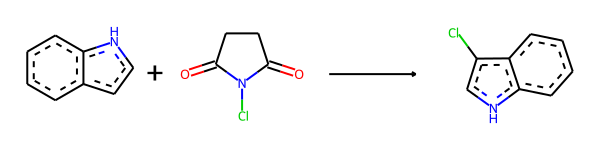

Identified carrier fragments for species c1ccc2[nH]ccc2c1 are: ['[H]n(c)c']. Input Y/N: Y
Identified carrier fragments for species O=C1CCC(=O)N1Cl are: ['O=C1CCC(=O)N1Cl']. Input Y/N: N
Do you want to specify expansion number (A) or carrier fragments directly (B): B
Please supply valid carrier fragments instead of ['O=C1CCC(=O)N1Cl']: Cl
Identified carrier fragments for species O=C1CCC(=O)N1Cl are: ['Cl']. Input Y/N: Y
Identified carrier fragments for species Clc1c[nH]c2ccccc12 are: ['cCl', '[H]n(c)c']. Input Y/N: Y


In [12]:
rdChemReactions.ReactionFromSmarts('c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',useSmiles=True)
demoquery=processquery('c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',debug=True)

In [13]:
demoquery

{'smiles': 'c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',
 'species': {'c1ccc2[nH]ccc2c1': {'[H]n(c)c': {'parent': 'c1ccc2[nH]ccc2c1',
    'count': 1,
    'expand': 1,
    'usermodified': False}},
  'O=C1CCC(=O)N1Cl': {'Cl': {'parent': 'O=C1CCC(=O)N1Cl',
    'count': 1,
    'expand': 1,
    'usermodified': True}},
  'Clc1c[nH]c2ccccc12': {'cCl': {'parent': 'Clc1c[nH]c2ccccc12',
    'count': 1,
    'expand': 1,
    'usermodified': False},
   '[H]n(c)c': {'parent': 'Clc1c[nH]c2ccccc12',
    'count': 1,
    'expand': 1,
    'usermodified': False}}}}

In [14]:
writepickle(demoquery,dmdir,'inputquery')
# demoquery=openpickle(dmdir+'inputquery')

In [20]:
demoquery2,fragdict=getanaloguespecies(demoquery,fragdb,SQL=False,refquery={},ncpus=16,fragtable=freqtable)

# Passing in pre-loaded fragment database is fastest (29 seconds) followed by database address (42 seconds) followed by
#SQL connection (1m 22.6 seconds) followed by SQL address (7 minutes)

2021-12-16 16:16:26,459	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [16]:
demoquery2
demoquery2['species']['O=C1CCC(=O)N1Cl']['Cl']['analoguepool']
fragdict

{'smiles': 'c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',
 'species': {'O=C1CCC(=O)N1Cl': {'Cl': {'parent': 'O=C1CCC(=O)N1Cl',
    'count': 1,
    'expand': 1,
    'usermodified': True,
    'analoguepool':              count                                             Smiles  \
    SubstanceID                                                             
    9019791          1  CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...   
    4584084          1  CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...   
    11095222         1  CC(C)[Si](Cc1cc(-c2ccccc2)nc2ccc(Cl)cc12)(C(C)...   
    10510505         1  CC(C)(C)[Si](C)(C)Oc1ccc2c(c1)CC[C@@H]1[C@@H]2...   
    1944772          1                              CCCCCCC(Cl)CNC(=O)OCC   
    ...            ...                                                ...   
    19547996         1  O.O=C([O-])C(=O)[O-].[Cl].[O-][Cl+3]([O-])([O-...   
    19547995         1  O.O=C([O-])C(=O)[O-].[Cl].[Nd+3].[O-][Cl+3]([O...   
    16763988       

,count,Smiles,>1 Compound
SubstanceID,,,
9019791,1,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False
4584084,1,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,False
11095222,1,CC(C)[Si](Cc1cc(-c2ccccc2)nc2ccc(Cl)cc12)(C(C)...,False
10510505,1,CC(C)(C)[Si](C)(C)Oc1ccc2c(c1)CC[C@@H]1[C@@H]2...,False
1944772,1,CCCCCCC(Cl)CNC(=O)OCC,False
...,...,...,...
19547996,1,O.O=C([O-])C(=O)[O-].[Cl].[O-][Cl+3]([O-])([O-...,True
19547995,1,O.O=C([O-])C(=O)[O-].[Cl].[Nd+3].[O-][Cl+3]([O...,True
16763988,1,CP(C)c1ccccc1.[Cl].[Cl]1[Pt]2[Cl][Pt]12,True


NameError: name 'fragdict' is not defined

In [ ]:
# demoquery3=updatequery(demoquery2, fragchoice={},similarity=True,fingerprint='morgan',morganradius=2,addHs=True,molwt=True) # Optional


In [15]:
# writepickle(demoquery2,dmdir,'inputquery_analg_compds')
demoquery2=openpickle(dmdir+'inputquery_analg_compds.pickle')

In [22]:
combinedpooldf=getcombinedpool(demoquery2,fragchoice={},ST=None,fingerprint='morgan',morganradius=2,MWT=None,nomixtures=True,res_format='df')
combinedpool=getcombinedpool(demoquery2,fragchoice={},ST=None,fingerprint='morgan',morganradius=2,MWT=None,nomixtures=True,res_format='list')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [103]:
combinedpooldf
combinedpool
len(combinedpool)

,count,Smiles,>1 Compound,FragmentSmiles,queryspecies
SubstanceID,,,,,
9019791,1,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False,Cl,O=C1CCC(=O)N1Cl
4584084,1,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,False,Cl,O=C1CCC(=O)N1Cl
11095222,1,CC(C)[Si](Cc1cc(-c2ccccc2)nc2ccc(Cl)cc12)(C(C)...,False,Cl,O=C1CCC(=O)N1Cl
10510505,1,CC(C)(C)[Si](C)(C)Oc1ccc2c(c1)CC[C@@H]1[C@@H]2...,False,Cl,O=C1CCC(=O)N1Cl
1944772,1,CCCCCCC(Cl)CNC(=O)OCC,False,Cl,O=C1CCC(=O)N1Cl
...,...,...,...,...,...
28068082,1,O=C(N/N=C/c1ncc[nH]1)C1CCCCC1,False,[H]n(c)c,c1ccc2[nH]ccc2c1
4406830,1,CNn1c(=O)[nH]c2ccccc21,False,[H]n(c)c,c1ccc2[nH]ccc2c1
6235669,1,O=c1[nH]c(Cl)nc2c1ncn2[C@H]1C[C@H](O)[C@H](O)[...,False,[H]n(c)c,c1ccc2[nH]ccc2c1


{4194306,
 4194307,
 4194311,
 4194312,
 4194314,
 12582924,
 12582925,
 4194323,
 4194324,
 4194325,
 12582931,
 12582935,
 29360152,
 4194329,
 20971546,
 4194331,
 4194332,
 29360154,
 20971550,
 20971551,
 29360153,
 4194330,
 29360157,
 29360158,
 29360159,
 29360162,
 29360161,
 29360160,
 29360165,
 29360168,
 29360163,
 4194347,
 29360169,
 4194349,
 29360166,
 20971567,
 29360167,
 29360170,
 29360171,
 29360172,
 4194356,
 29360182,
 4194359,
 29360183,
 9836696,
 29360186,
 20971579,
 29360187,
 29360188,
 29360190,
 29360191,
 29360192,
 29360193,
 29360194,
 4194367,
 29360196,
 29360197,
 29360199,
 29360200,
 29360201,
 29360202,
 4194376,
 29360204,
 29360208,
 29360209,
 4194387,
 20971604,
 9503250,
 4194402,
 4194406,
 4194408,
 4194413,
 4194414,
 29360239,
 4194416,
 29360241,
 4194418,
 4194420,
 29360244,
 29360246,
 4194423,
 15839383,
 29360249,
 29360250,
 29360251,
 29360252,
 4194427,
 29360253,
 29360255,
 29360257,
 29360258,
 29360259,
 29360260,
 2936026

2400491

In [17]:
# pd.to_pickle(combinedpooldf,dmdir+'combinedpooldf.pickle')
# writepickle(combinedpool,dmdir,'combinedpool')
combinedpool=openpickle(dmdir+'combinedpool.pickle')

In [21]:
exemptionlist=openpickle(exemptiondir) #Catalysts misclassified as reagents (uncertain)
combinedpoolex=updatecombinedpool(combinedpool,exemptionlist=exemptionlist)

In [24]:
writepickle(combinedpoolex,dmdir,'combinedpoolex')
# combinedpoolex=openpickle(dmdir+'combinedpoolex.pickle')

In [22]:
combinedpoolex
len(combinedpoolex)

{16777320,
 25166228,
 25166230,
 464,
 25166370,
 16777896,
 16777969,
 16777975,
 983,
 985,
 988,
 1021,
 1035,
 1036,
 1040,
 1044,
 1045,
 1055,
 1062,
 1106,
 1108,
 1114,
 1130,
 1142,
 1154,
 1159,
 1176,
 1184,
 1199,
 1202,
 1222,
 1263,
 1279,
 1293,
 1299,
 1325,
 1327,
 1336,
 1345,
 1368,
 1398,
 1400,
 1406,
 1429,
 1453,
 1457,
 1458,
 1471,
 1485,
 1500,
 1509,
 1520,
 1526,
 1527,
 8390144,
 1538,
 1543,
 1548,
 1566,
 1569,
 1599,
 1615,
 1616,
 1617,
 1633,
 1636,
 1637,
 1638,
 1639,
 1649,
 1658,
 1659,
 1701,
 1703,
 1711,
 1715,
 1718,
 1721,
 1733,
 1760,
 8390374,
 1773,
 1794,
 1799,
 1815,
 1825,
 1826,
 1828,
 1829,
 1831,
 1839,
 1849,
 1852,
 1858,
 1859,
 1864,
 1871,
 1876,
 1878,
 1882,
 8390507,
 1903,
 8390516,
 1927,
 8390542,
 8390543,
 1964,
 1965,
 1966,
 1968,
 1970,
 1971,
 1973,
 1974,
 1977,
 1980,
 1999,
 2005,
 2006,
 2010,
 16779227,
 2011,
 2012,
 2020,
 2021,
 2034,
 2039,
 2041,
 2052,
 2064,
 2071,
 2078,
 2086,
 2097,
 2101,
 2110,
 2

2432749

In [27]:
reactiondb=pd.read_pickle(rxnsource)

In [28]:
reactiondb

,NumRefs,ReactantID,ProductID,NumSteps,ReagentID,Temperature,Pressure,ReactionTime,SolventID,CatalystID,ReactionType
ReactionID,,,,,,,,,,,
9338524,1,"[2206190, 638342, 9469404]",[9471480],[1],[605283],[20.0],[],[12],[1731042],[],None
25983699,1,"[2208086, 531597]",[15810597],[1],[4267587],[100.0],[],[5],[106420],[],None
36297537,1,"[3530413, 605259]",[12631839],[1],[1209273],[],[],[],[102391],[],None
43486591,1,"[2238689, 30065685]",[30065603],[1],[26652065],[0.0],[],[12],[635760],[],None
26266068,1,"[11323698, 11342951, 4122948]",[16682893],[1],[],[],[],[],[],[],None
...,...,...,...,...,...,...,...,...,...,...,...
3496420,1,[6265578],[6260891],[1],[1446024],[],[],[],[],[],None
28332966,1,"[16771945, 1908447]",[19025030],[1],[],[],[],[],[1730800],[],None
25346578,1,"[15273722, 463688]",[458014],[1],[],[],[],[],"[3587155, 635680]",[],None


In [83]:
analgdict=getanaloguerxns(reactiondb,combinedpool,combinedpoolex=combinedpoolex, workflow='strict',returnall=True,reaxys_update=False,refanaloguerxns=None,ncpus=16)

2021-12-17 01:15:50,685	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [ ]:
analgdict=getanaloguerxns(reactiondb,combinedpool,combinedpoolex=combinedpoolex, workflow='strict',returnall=True,reaxys_update=True,refanaloguerxns=None,ncpus=16)

2021-12-17 01:27:54,579	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-17 01:29:52,027	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [27]:
# writepickle(analgdict,dmdir,'analgrxns')
analgdict=pd.read_pickle(dmdir+'analgrxns.pickle')

In [31]:
analoguerxns=analgdict['loosest']['analoguerxns']
analoguerxns
analoguerxns.loc[(analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False,na=False)) & (~analoguerxns.ReagentID.astype(bool)) & (~analoguerxns.SolventID.astype(bool)) & (~analoguerxns.Temperature.astype(bool)) & (~analoguerxns.Pressure.astype(bool)) & (~analoguerxns.ReactionTime.astype(bool)) & (~analoguerxns.CatalystID.astype(bool))]

# analgdict['strict']['analoguerxns']

,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
0,68001,3,"[110145, 471359]",[],[162172],[],1,2,"[103233, 1098214]",[],...,[2],"[1731042, 1731042, 3587155]",[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2018],{162172: 70.0}
1,68001,3,"[110145, 471359]",[],[162172],[],1,1,[103233],[],...,[],[],[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[1949],{}
2,68001,3,"[110145, 471359]",[],[162172],[],1,1,[605283],[],...,[1],[1730800],[],[],[],Heating,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2002],{}
3,383983,2,[2694054],[],[3398094],[],1,1,"[3587158, 506007, 969616]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1956],{}
4,383983,2,[2694054],[],[3398094],[],1,1,"[11342918, 3587194, 506007]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1958],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358438,45351339,1,[31201625],[],[31201627],[],1,1,[742035],[],...,[4],[1098229],[],[],[],Inert atmosphere,[],{31201625: '(S)-tert-butyl (1-(2-cyano-4-(2-me...,[2017],{31201627: 48.0}
1358439,46546703,1,[31906875],[],[31906847],[],1,1,[3556712],[],...,[2],[506008],[],[],[],"Green chemistry, regiospecific reaction",[],{31906875: 'C<sub>18</sub>H<sub>19</sub>ClFNO'...,[2017],{31906847: 86.0}
1358440,41310364,1,[28783542],[],[28783556],[],1,1,[3615340],[],...,[2],[],[],[],[],"Inert atmosphere, Sealed tube",[],"{28783542: '(3',5'-dichloro-2,6-dimethoxybiphe...",[2015],{28783556: 96.0}
1358441,40504203,1,[28388225],[],[28388226],[],1,1,"[3587155, 8128150]",[],...,[2],[1098229],[],[],[],,[],{28388225: 'methyl 4-[[2-(tert-butoxycarbonyla...,[2015],{}


,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
3721,3778777,1,[760196],[],[760197],[],1,1,[],[],...,[],[],[],[],[],"Ambient temperature, Irradiation, photoequilib...",[],"{760196: 'xanthobilirubic acid', 760197: 'xant...",[1983],{}
17357,8050495,1,[386014],"[I<sub>2</sub>, AgNO<sub>3</sub>]",[3089091],[],1,1,[],[],...,[],[],[],[],[],"Ambient temperature, Yield given",[],"{386014: 'para-chloroacetophenone', 3089091: '...",[1982],{}
48842,3590994,1,[6441559],[],[6421975],[],1,1,[],[],...,[],[],[],[],[],"Ambient temperature, Yield given",[],{6441559: 'C<sub>24</sub>H<sub>29</sub>ClO<sub...,[1985],{}
57606,4251742,1,[1904175],[],"[1849970, 1921816]",[],1,1,[],[],...,[],[],[],[],[],"Ambient temperature, Irradiation",[],"{1904175: '2-methylchlorobenzene', 1849970: 'b...",[1986],{}
73206,6995821,4,"[1813670, 3902968]",[],[1813758],[],1,1,[],[],...,[],[],[neat (no solvent)],[],[],warming in sealed tube from -78°C to ambient t...,[],{1813670: 'Bis(heptafluor-n-propyl)-chlorphosp...,[1959],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316521,3473305,1,[6191252],[],"[1696840, 4741596]",[],1,1,[],[],...,[],[],[],[],[],Ambient temperature,[],"{6191252: 'Phenyl-methylthio-chlorphosphan', 1...",[1988],{}
1328233,2585844,1,[4507174],[],[4430422],[],1,1,[],[],...,[],[],[],[],[],"Ambient temperature, several weeks",[],"{4507174: '8-Acetoxy-3-methyl-1,4,5,6,7,8-hexa...",[1987],{}
1345830,3351187,1,"[4361019, 605395]",[],"[1855757, 6190167]",[],1,1,[],[],...,[],[],[],[],[],Ambient temperature,[],"{4361019: '1,1-Dichloroethyl hydroperoxide', 6...",[1985],{6190167: 36.0}
1346300,2251912,1,"[3587199, 6503619]",[],"[6501225, 6555674]",[],1,1,[],[],...,[],[],[],[],[],"Ambient temperature, Title compound not separa...",[],"{3587199: 'methylmagnesium chloride', 6503619:...",[1988],{}


In [118]:
analoguerxns.loc[analoguerxns.MissingCatalyst.astype(bool)]
analoguerxns.loc[(analoguerxns.ReagentID.astype(bool)) | (analoguerxns.SolventID.astype(bool)) | (analoguerxns.Temperature.astype(bool))| (analoguerxns.Pressure.astype(bool))| (analoguerxns.ReactionTime.astype(bool))| (analoguerxns.CatalystID.astype(bool)) | (analoguerxns.MissingSolvent.astype(bool)) | (analoguerxns.MissingCatalyst.astype(bool))]
analoguerxns.loc[(analoguerxns.ReagentID.astype(bool)) | (analoguerxns.SolventID.astype(bool)) | (analoguerxns.Temperature.astype(bool))| (analoguerxns.Pressure.astype(bool))| (analoguerxns.ReactionTime.astype(bool))| (analoguerxns.CatalystID.astype(bool))]

,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
291,9440899,1,[9544842],[],[9544637],[],1,1,[3587189],[],...,[],[1718733],[],[],[5percent Pd/C],,[],{9544842: 'C<sub>96</sub>H<sub>126</sub>N<sub>...,[2003],{9544637: 69.0}
1702,11268621,1,"[1209232, 385877]",[],"[11282163, 11282164]",[],1,1,[8973685],[],...,[48],[102391],[],[],"[chiral 1,2-diphenyl-ethane-1,2-diamine-based ...",Title compound not separated from byproducts.,[],"{1209232: 'chloro-trimethyl-silane', 385877: '...",[2007],{}
2612,25921658,2,[2331589],[],"[1318743, 1623721]",[],1,1,"[11342937, 202022]",[],...,[8],[635760],[],[],[O-benzyldemethoxydihydroquinine bromo(9-anthr...,Title compound not separated from byproducts.,[],"{2331589: '1,3-bis(4-chlorophenyl)prop-2-en-1-...",[2007],{}
3605,8787127,1,[8796269],[],[8791193],[],1,1,"[3587189, 3595639]",[],...,[1],[1718733],[],[],[5percent Pd/C],,[],{8796269: '7-chloro-3-(4-fluoro-phenyl)-2-(4-m...,[2001],{8791193: 71.0}
4028,29770740,1,[20724217],[],[20724216],[],1,1,[878137],[],...,[0.25],[102391],[],[],[Raney nickel],"Inert atmosphere, Sealed flask",[],{20724217: '(6-chloro-pyridin-3-ylmethyl)-(5-n...,[2010],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354807,11197124,1,[617448],[BrZnCH<sub>2</sub>COOEt],[11202145],[],1,1,[],[],...,[12],[102391],[],[],[Pd<sub>2</sub>dba3/(2-biphenyl)di-tert-butylp...,,[],{617448: '6-chloro-9-(tetrahydro-2H-pyran-2-yl...,[2007],{11202145: 76.0}
1355770,9154147,12,[8414155],[],[8552798],[],1,1,[3587189],[],...,[12],[1730800],[],[],"[rhodium(I), 2,5-di[(S)-BINOL-phosphanyloxy]bi...",,[],{8414155: '(Z)-2-acetylamino-3-(2-chlorophenyl...,[2007],{8552798: 99.0}
1356356,2088363,1,[2092900],[],"[1305151, 1948093, 2122051]",[],1,1,[],[],...,[6],[2037554],[],[],[H<sub>2</sub>SO<sub>4</sub>],,[],"{2092900: '4-(3-chloro-2-butenoxy)toluene', 13...",[1982],{}
1357184,11197122,1,[226271],[BrZnCH<sub>2</sub>COOEt],[11202144],[],1,1,[],[],...,[12],[102391],[],[],[Pd<sub>2</sub>dba3/(2-biphenyl)di-tert-butylp...,,[],"{226271: '9-benzyl-6-chloro-9H-purine', 112021...",[2007],{11202144: 91.0}


,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
0,68001,3,"[110145, 471359]",[],[162172],[],1,2,"[103233, 1098214]",[],...,[2],"[1731042, 1731042, 3587155]",[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2018],{162172: 70.0}
1,68001,3,"[110145, 471359]",[],[162172],[],1,1,[103233],[],...,[],[],[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[1949],{}
2,68001,3,"[110145, 471359]",[],[162172],[],1,1,[605283],[],...,[1],[1730800],[],[],[],Heating,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2002],{}
3,383983,2,[2694054],[],[3398094],[],1,1,"[3587158, 506007, 969616]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1956],{}
4,383983,2,[2694054],[],[3398094],[],1,1,"[11342918, 3587194, 506007]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1958],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358438,45351339,1,[31201625],[],[31201627],[],1,1,[742035],[],...,[4],[1098229],[],[],[],Inert atmosphere,[],{31201625: '(S)-tert-butyl (1-(2-cyano-4-(2-me...,[2017],{31201627: 48.0}
1358439,46546703,1,[31906875],[],[31906847],[],1,1,[3556712],[],...,[2],[506008],[],[],[],"Green chemistry, regiospecific reaction",[],{31906875: 'C<sub>18</sub>H<sub>19</sub>ClFNO'...,[2017],{31906847: 86.0}
1358440,41310364,1,[28783542],[],[28783556],[],1,1,[3615340],[],...,[2],[],[],[],[],"Inert atmosphere, Sealed tube",[],"{28783542: '(3',5'-dichloro-2,6-dimethoxybiphe...",[2015],{28783556: 96.0}
1358441,40504203,1,[28388225],[],[28388226],[],1,1,"[3587155, 8128150]",[],...,[2],[1098229],[],[],[],,[],{28388225: 'methyl 4-[[2-(tert-butoxycarbonyla...,[2015],{}


,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
0,68001,3,"[110145, 471359]",[],[162172],[],1,2,"[103233, 1098214]",[],...,[2],"[1731042, 1731042, 3587155]",[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2018],{162172: 70.0}
1,68001,3,"[110145, 471359]",[],[162172],[],1,1,[103233],[],...,[],[],[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[1949],{}
2,68001,3,"[110145, 471359]",[],[162172],[],1,1,[605283],[],...,[1],[1730800],[],[],[],Heating,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2002],{}
3,383983,2,[2694054],[],[3398094],[],1,1,"[3587158, 506007, 969616]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1956],{}
4,383983,2,[2694054],[],[3398094],[],1,1,"[11342918, 3587194, 506007]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1958],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358438,45351339,1,[31201625],[],[31201627],[],1,1,[742035],[],...,[4],[1098229],[],[],[],Inert atmosphere,[],{31201625: '(S)-tert-butyl (1-(2-cyano-4-(2-me...,[2017],{31201627: 48.0}
1358439,46546703,1,[31906875],[],[31906847],[],1,1,[3556712],[],...,[2],[506008],[],[],[],"Green chemistry, regiospecific reaction",[],{31906875: 'C<sub>18</sub>H<sub>19</sub>ClFNO'...,[2017],{31906847: 86.0}
1358440,41310364,1,[28783542],[],[28783556],[],1,1,[3615340],[],...,[2],[],[],[],[],"Inert atmosphere, Sealed tube",[],"{28783542: '(3',5'-dichloro-2,6-dimethoxybiphe...",[2015],{28783556: 96.0}
1358441,40504203,1,[28388225],[],[28388226],[],1,1,"[3587155, 8128150]",[],...,[2],[1098229],[],[],[],,[],{28388225: 'methyl 4-[[2-(tert-butoxycarbonyla...,[2015],{}


In [123]:
analoguerxns.loc[analoguerxns.ConditionNotes.str.contains('ambient temperature',case=False)][['Temperature']]
analoguerxns['Temperature']
analoguerxns.loc[7]

,Temperature
7,20
11,20
27,20
28,20
33,20
...,...
1358352,20
1358355,20
1358379,20
1358402,20


0               [0]
1                []
2                []
3                []
4                []
             ...   
1358438    [0 - 20]
1358439       [100]
1358440       [220]
1358441        [80]
1358442          []
Name: Temperature, Length: 1358443, dtype: object

ReactionID                                                    717942
NumRefs                                                            3
ReactantID                                         [2091633, 605969]
MissingReactant                                                   []
ProductID                                                  [3120344]
MissingProduct                                                    []
NumSteps                                                           1
NumStages                                                          1
ReagentID                                                         []
MissingReagent                                                    []
Temperature                                                       20
Pressure                                                          []
ReactionTime                                                    [48]
SolventID                                                         []
MissingSolvent                    

In [79]:
analgdict2=getanaloguerxns(reactiondb,combinedpool,combinedpoolex=combinedpoolex, workflow='strictest',returnall=False,reaxys_update=True,refanaloguerxns=None,ncpus=16)

2021-12-17 00:38:02,549	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-17 00:40:13,863	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-17 01:02:43,190	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-17 01:02:51,118	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-17 01:02:57,864	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-17 01:03:32,024	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [52]:
updateanaloguerxns(analoguerxns2.iloc[:10000])

2021-12-16 17:29:02,489	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
0,200764,1,[1721759],[],[1751570],[],1,1,[969177],[],...,[],[],[],[],[],und Behandeln des Reaktionsprodukts mit wss.Am...,[],"{1721759: '2-chlorohexanoic acid', 1751570: '2...",[1953],{}
1,626919,2,"[1862539, 473741]",[],[3414306],[],1,1,[],[],...,[],[],[],[],[],,[],"{1862539: '4-Chloro-3,5-dimethylphenol', 47374...","[1934, 1936]",{}
2,689957,2,"[1722989, 605303]",[],[1710002],[],1,1,[],[],...,[],[],[],[],[],,[],"{1722989: '4,4,4-trichloro-3-hydroxybutyric ac...","[1974, 1913]",{}
3,717942,3,"[2091633, 605969]",[],[3120344],[],1,1,[],[],...,[48],[],[],[],[],Ambient temperature,[],"{2091633: '4-Fluorobenzenesulfonyl chloride', ...",[1984],{3120344: 86.0}
4,717942,3,"[2091633, 605969]",[],[3120344],[],1,1,[],[],...,[1],"[103233, 1098229]",[],[],[],,[],"{2091633: '4-Fluorobenzenesulfonyl chloride', ...",[1986],{3120344: 68.0}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11680,41409769,1,[28845199],[],[28845226],[],1,1,"[1361988, 605365]",[],...,[3],[1730800],[],[],[],,[],{28845199: '2-(4-chlorophenoxy)-2-fluoroacetic...,[2015],{}
11681,42343255,2,[29374273],[],[29374264],[],1,1,[1209273],[],...,[1],[],[],[],[],Reflux,[],{29374273: 'C<sub>11</sub>H<sub>7</sub>ClN<sub...,[2016],{}
11682,42343255,2,[29374273],[],[29374264],[],1,1,[1361988],[],...,[0.5],"[1730800, 605365]",[],[],[],,[],{29374273: 'C<sub>11</sub>H<sub>7</sub>ClN<sub...,[2016],{}
11683,43044077,1,[27700203],[],[29752273],[],1,1,[1209273],[],...,[],[],[],[],[],,[],{27700203: 'C<sub>11</sub>H<sub>9</sub>Cl<sub>...,[2016],{29752273: 63.0}


In [32]:
unresolvedids=openpickle(unresolveddir)

In [33]:
unresolvedids

{16777216,
 1,
 16777223,
 8388629,
 16777240,
 20971545,
 16777244,
 16777247,
 29360173,
 8388667,
 16777286,
 29360211,
 29360212,
 29360213,
 29360214,
 29360215,
 29360216,
 16777304,
 8388693,
 8388699,
 29360220,
 29360221,
 16777370,
 29360285,
 29343364,
 29360287,
 29360288,
 29360289,
 29360296,
 29360298,
 29360299,
 29360300,
 8388788,
 29360309,
 29360310,
 29360311,
 29360312,
 8388789,
 16777402,
 8388796,
 8388803,
 8388806,
 8388807,
 8388808,
 8388810,
 8388811,
 8388812,
 16777421,
 8388854,
 8388855,
 8388857,
 16777465,
 8388870,
 8388871,
 8388872,
 8388873,
 8388875,
 8388876,
 8388877,
 8388878,
 8388879,
 8388881,
 8388882,
 8388883,
 8388884,
 8388886,
 8388887,
 8388888,
 8388890,
 8388891,
 8388893,
 8388894,
 16777503,
 8388895,
 8388897,
 8388898,
 8388899,
 8388900,
 8388901,
 8388903,
 8388904,
 8388906,
 8388907,
 8388908,
 8388909,
 8388911,
 8388912,
 8388914,
 8388915,
 16777541,
 4194660,
 4194663,
 16777581,
 16777620,
 4194717,
 12583327,
 125833

In [131]:
analoguerxns2=filteranaloguerxns(analoguerxns,unresolvedids,reaxys_update=True,exemptionlist=exemptionlist)

86.37% reactions remaining after cleaning


In [35]:
analoguerxns2

,ReactionID,NumRefs,ReactantID,MissingReactant,ProductID,MissingProduct,NumSteps,NumStages,ReagentID,MissingReagent,...,ReactionTime,SolventID,MissingSolvent,CatalystID,MissingCatalyst,ConditionNotes,ReactionType,NameDict,YearPublished,Yield
0,68001,3,"[110145, 471359]",[],[162172],[],1,2,"[103233, 1098214]",[],...,[2],"[1731042, 1731042, 3587155]",[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2018],{162172: 70.0}
1,68001,3,"[110145, 471359]",[],[162172],[],1,1,[103233],[],...,[],[],[],[],[],,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[1949],{}
2,68001,3,"[110145, 471359]",[],[162172],[],1,1,[605283],[],...,[1],[1730800],[],[],[],Heating,[],"{110145: '2-Thiophenecarbonyl chloride', 47135...",[2002],{}
3,383983,2,[2694054],[],[3398094],[],1,1,"[3587158, 506007, 969616]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1956],{}
4,383983,2,[2694054],[],[3398094],[],1,1,"[11342918, 3587194, 506007]",[],...,[],[],[],[],[],,[],"{2694054: '2,5-dibromobenzenesulfonyl chloride...",[1958],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358438,45351339,1,[31201625],[],[31201627],[],1,1,[742035],[],...,[4],[1098229],[],[],[],Inert atmosphere,[],{31201625: '(S)-tert-butyl (1-(2-cyano-4-(2-me...,[2017],{31201627: 48.0}
1358439,46546703,1,[31906875],[],[31906847],[],1,1,[3556712],[],...,[2],[506008],[],[],[],"Green chemistry, regiospecific reaction",[],{31906875: 'C<sub>18</sub>H<sub>19</sub>ClFNO'...,[2017],{31906847: 86.0}
1358440,41310364,1,[28783542],[],[28783556],[],1,1,[3615340],[],...,[2],[],[],[],[],"Inert atmosphere, Sealed tube",[],"{28783542: '(3',5'-dichloro-2,6-dimethoxybiphe...",[2015],{28783556: 96.0}
1358441,40504203,1,[28388225],[],[28388226],[],1,1,"[3587155, 8128150]",[],...,[2],[1098229],[],[],[],,[],{28388225: 'methyl 4-[[2-(tert-butoxycarbonyla...,[2015],{}


In [34]:
# pd.to_pickle(analoguerxns2,dpdir+'analgrxnsfinal.pickle')
analoguerxns2=pd.read_pickle(dpdir+'analgrxnsfinal.pickle')

In [59]:
analoguerxns3=addspeciesdata(analoguerxns2,substancesource,includesolv=True,ncpus=16,SQL=False,reaxys_update=True,hc_Dict=hc_Dict,hc_rct=hc_rct)

2021-12-19 17:44:00,013	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [44]:
analoguerxns3

,ReactionID,ReactantID,ProductID,NumRefs,NumSteps,NumStages,ReagentID,SolventID,Rdata,Pdata,Rgtdata,Solvdata,hc_prod,hc_react
0,68001,"[110145, 471359]",[162172],3,1,2,"[103233, 1098214]","[1731042, 1731042, 3587155]","{110145: {'atomdict': {'O': 1, 'C': 5, 'Cl': 1...","{162172: {'atomdict': {'O': 1, 'C': 11, 'N': 1...","{103233: {'atomdict': {'C': 5, 'N': 1, 'H': 5}...","{1731042: {'atomdict': {'Cl': 3, 'C': 1, 'H': ...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
1,68001,"[110145, 471359]",[162172],3,1,1,[103233],[],"{110145: {'atomdict': {'O': 1, 'C': 5, 'Cl': 1...","{162172: {'atomdict': {'O': 1, 'C': 11, 'N': 1...","{103233: {'atomdict': {'C': 5, 'N': 1, 'H': 5}...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
2,68001,"[110145, 471359]",[162172],3,1,1,[605283],[1730800],"{110145: {'atomdict': {'O': 1, 'C': 5, 'Cl': 1...","{162172: {'atomdict': {'O': 1, 'C': 11, 'N': 1...","{605283: {'atomdict': {'C': 6, 'N': 1, 'H': 15...","{1730800: {'atomdict': {'Cl': 2, 'C': 1, 'H': ...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
3,383983,[2694054],[3398094],2,1,1,"[3587158, 506007, 969616]",[],"{2694054: {'atomdict': {'O': 2, 'S': 1, 'Cl': ...","{3398094: {'atomdict': {'Br': 4, 'C': 12, 'S':...","{969616: {'atomdict': {'O': 1, 'C': 6, 'H': 6}...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
4,383983,[2694054],[3398094],2,1,1,"[11342918, 3587194, 506007]",[],"{2694054: {'atomdict': {'O': 2, 'S': 1, 'Cl': ...","{3398094: {'atomdict': {'Br': 4, 'C': 12, 'S':...","{3587194: {'atomdict': {'I': 2}, 'charge': 0, ...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358438,45351339,[31201625],[31201627],1,1,1,[742035],[1098229],"{31201625: {'atomdict': {'C': 27, 'O': 3, 'N':...","{31201627: {'atomdict': {'C': 22, 'O': 1, 'N':...","{742035: {'atomdict': {'O': 2, 'C': 2, 'F': 3,...","{1098229: {'atomdict': {'C': 1, 'O': 1, 'H': 4...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
1358439,46546703,[31906875],[31906847],1,1,1,[3556712],[506008],"{31906875: {'atomdict': {'C': 18, 'N': 1, 'Cl'...","{31906847: {'atomdict': {'C': 18, 'N': 1, 'O':...","{3556712: {'atomdict': {'C': 4, 'O': 1, 'K': 1...","{506008: {'atomdict': {'C': 2, 'S': 1, 'O': 1,...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
1358440,41310364,[28783542],[28783556],1,1,1,[3615340],[],"{28783542: {'atomdict': {'C': 23, 'O': 3, 'Cl'...","{28783556: {'atomdict': {'C': 21, 'O': 3, 'Cl'...","{3615340: {'atomdict': {'Cl': 1, 'C': 5, 'N': ...",{},"{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."
1358441,40504203,[28388225],[28388226],1,1,1,"[3587155, 8128150]",[1098229],"{28388225: {'atomdict': {'C': 26, 'N': 4, 'O':...","{28388226: {'atomdict': {'C': 25, 'N': 4, 'O':...","{3587155: {'atomdict': {'O': 1, 'H': 2}, 'char...","{1098229: {'atomdict': {'C': 1, 'O': 1, 'H': 4...","{0: {'atomdict': {'C': 2, 'O': 2, 'H': 4}, 'ch...","{1: {'atomdict': {'O': 1, 'H': 2}, 'charge': 0..."


For balancing, there are message outputs: Already balanced (reaction is balanced as represented in Reaxys), balanced * with (reaction has been balanced with added species (reactants, reagents), help products or help reactants), 'Warning. Coeffs High' (reaction has been balanced but coefficients are very high suggesting a false positive), 'Imbalanced * with (Reaction is imbalanced with potentially compatible LHS species), 'Invalid balancing' (Balancing is invalid or wrong due to moving species from LHS to RHS, missing species, inability to resolve duplicate molecular formulae), 'LHS species insufficient' (Reaction lacks species on LHS for balancing)

Reaction is fully balanced


('CCCC/C(Cl)=C\\C(=O)[Si](C)(C)C>>CCCC=C(Cl)CC(=O)[Si](C)(C)C',
 'CCCC/C(Cl)=C\\C(=O)[Si](C)(C)C>>CCCC=C(Cl)CC(=O)[Si](C)(C)C',
 'Already balanced',
 [5806643],
 [7287896],
 [],
 [],
 {5806643: {'atomdict': {'C': 10, 'Cl': 1, 'O': 1, 'Si': 1, 'H': 19},
   'charge': 0,
   'smiles': 'CCCC/C(Cl)=C\\C(=O)[Si](C)(C)C',
   'formula': 'C10H19ClOSi',
   'count': 1}},
 {7287896: {'atomdict': {'C': 10, 'Cl': 1, 'O': 1, 'Si': 1, 'H': 19},
   'charge': 0,
   'smiles': 'CCCC=C(Cl)CC(=O)[Si](C)(C)C',
   'formula': 'C10H19ClOSi',
   'count': 1}})

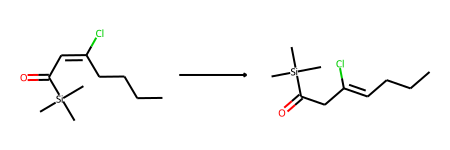

In [77]:
balance_analogue(analoguerxns3.iloc[30],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('CCCC/C(Cl)=C\\C(=O)[Si](C)(C)C>>CCCC=C(Cl)CC(=O)[Si](C)(C)C',useSmiles=True)

Reaction successfully balanced


('OC(c1ccc(Cl)cc1)P(c1ccccc1)c1ccccc1>>O=P(c1ccccc1)(c1ccccc1)C(O)c1ccc(Cl)cc1',
 'OC(c1ccc(Cl)cc1)P(c1ccccc1)c1ccccc1.OO>>O=P(c1ccccc1)(c1ccccc1)C(O)c1ccc(Cl)cc1.O',
 'Balanced with species: 3587191 with help product(s): H2O',
 [2989585, 3587191],
 [2947359],
 [],
 [1],
 {2989585: {'atomdict': {'O': 1, 'C': 19, 'Cl': 1, 'P': 1, 'H': 16},
   'charge': 0,
   'smiles': 'OC(c1ccc(Cl)cc1)P(c1ccccc1)c1ccccc1',
   'formula': 'C19H16ClOP',
   'count': 1},
  3587191: {'atomdict': {'O': 2, 'H': 2},
   'charge': 0,
   'smiles': 'OO',
   'formula': 'H2O2',
   'count': 1}},
 {2947359: {'atomdict': {'O': 2, 'P': 1, 'C': 19, 'Cl': 1, 'H': 16},
   'charge': 0,
   'smiles': 'O=P(c1ccccc1)(c1ccccc1)C(O)c1ccc(Cl)cc1',
   'formula': 'C19H16ClO2P',
   'count': 1},
  1: {'atomdict': {'O': 1, 'H': 2},
   'charge': 0,
   'smiles': 'O',
   'formula': 'H2O',
   'count': 1,
   'rxs_ids': [16478368,
    18259376,
    16999929,
    17669282,
    16532872,
    28692842,
    15936966,
    3587155,
    16490171,
   

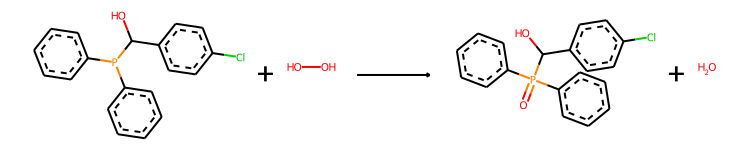

In [72]:
balance_analogue(analoguerxns3.iloc[10],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('OC(c1ccc(Cl)cc1)P(c1ccccc1)c1ccccc1.OO>>O=P(c1ccccc1)(c1ccccc1)C(O)c1ccc(Cl)cc1.O',useSmiles=True)

Reaction successfully balanced


('O=C(Cl)c1cccs1.Nc1ccc(Cl)cc1>>O=C(Nc1ccc(Cl)cc1)c1cccs1',
 'O=C(Cl)c1cccs1.Nc1ccc(Cl)cc1>>O=C(Nc1ccc(Cl)cc1)c1cccs1.Cl',
 'Balanced with help product(s): HCl',
 [110145, 471359],
 [162172],
 [],
 [11],
 {110145: {'atomdict': {'O': 1, 'C': 5, 'Cl': 1, 'S': 1, 'H': 3},
   'charge': 0,
   'smiles': 'O=C(Cl)c1cccs1',
   'formula': 'C5H3ClOS',
   'count': 1},
  471359: {'atomdict': {'N': 1, 'C': 6, 'Cl': 1, 'H': 6},
   'charge': 0,
   'smiles': 'Nc1ccc(Cl)cc1',
   'formula': 'C6H6ClN',
   'count': 1}},
 {162172: {'atomdict': {'O': 1, 'C': 11, 'N': 1, 'Cl': 1, 'S': 1, 'H': 8},
   'charge': 0,
   'smiles': 'O=C(Nc1ccc(Cl)cc1)c1cccs1',
   'formula': 'C11H8ClNOS',
   'count': 1},
  11: {'atomdict': {'Cl': 1, 'H': 1},
   'charge': 0,
   'smiles': 'Cl',
   'formula': 'HCl',
   'count': 1,
   'rxs_ids': [24608586,
    16836402,
    14681183,
    3587171,
    15913435,
    16501060,
    7801727,
    16270663,
    19834398,
    1098214,
    16475562,
    16502419,
    3587163]}})

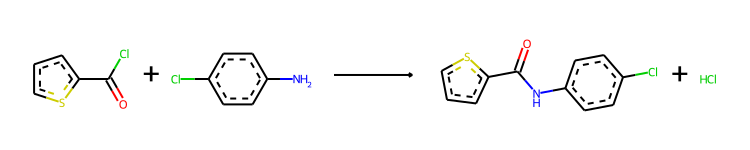

In [70]:
balance_analogue(analoguerxns3.iloc[0],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('O=C(Cl)c1cccs1.Nc1ccc(Cl)cc1>>O=C(Nc1ccc(Cl)cc1)c1cccs1.Cl',useSmiles=True)

('N#CC1(Cl)CCCCC1.CC(C)(C)C(=O)Cl>>CC(C)(C)C(=O)C1(C#N)CCCCC1',
 'N#CC1(Cl)CCCCC1.CC(C)(C)C(=O)Cl>>CC(C)(C)C(=O)C1(C#N)CCCCC1',
 'Imbalanced',
 [3234112, 385668],
 [9699313],
 [],
 [],
 {3234112: {'atomdict': {'N': 1, 'C': 7, 'Cl': 1, 'H': 10},
   'charge': 0,
   'smiles': 'N#CC1(Cl)CCCCC1',
   'formula': 'C7H10ClN',
   'count': 1},
  385668: {'atomdict': {'C': 5, 'O': 1, 'Cl': 1, 'H': 9},
   'charge': 0,
   'smiles': 'CC(C)(C)C(=O)Cl',
   'formula': 'C5H9ClO',
   'count': 1}},
 {9699313: {'atomdict': {'C': 12, 'O': 1, 'N': 1, 'H': 19},
   'charge': 0,
   'smiles': 'CC(C)(C)C(=O)C1(C#N)CCCCC1',
   'formula': 'C12H19NO',
   'count': 1}})

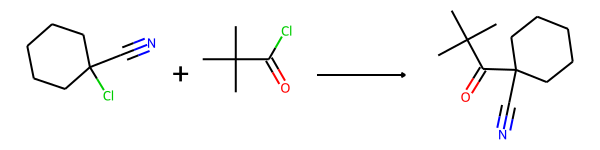

In [68]:
balance_analogue(analoguerxns3.iloc[50],basic=True,balance=True,coefflim=5,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('N#CC1(Cl)CCCCC1.CC(C)(C)C(=O)Cl>>CC(C)(C)C(=O)C1(C#N)CCCCC1',useSmiles=True)

Help compounds did not help. Extra reactant atoms


('CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl>>C[C@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl',
 'CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl.CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl.CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl>>C[C@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl',
 'Imbalanced with species: 4783054,4783054',
 [4783054, 4783054, 4783054],
 [4781044, 4363510, 4783055],
 [],
 [],
 {4783054: {'atomdict': {'C': 12, 'O': 3, 'Si': 1, 'Cl': 1, 'H': 25},
   'charge': 0,
   'smiles': 'CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl',
   'formula': 'C12H25ClO3Si',
   'count': 3}},
 {4781044: {'atomdict': {'C': 10, 'O': 2, 'Si': 1, 'H': 24},
   'charge': 0,
   'smiles': 'C[C@H](O)CCO[Si](C)(C)C(C)(C)C',
   'formula': 'C10H24O2Si',
   'count': 1},
  4363510: {'atomdict': {'C': 10, 'O': 2, 'Si': 1, 'H': 24},
   'charge': 0,
   'smiles': 'C[C@@H](O)CCO[Si](C)(C)C(C)(C)C',
   'formula': 'C10H24O2Si',
   'count': 1},
  478305

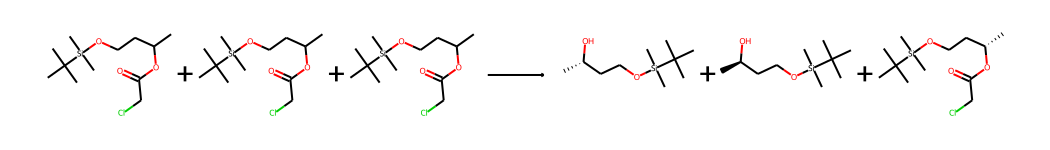

Help compounds did not help. Extra reactant atoms


('C#CCOC(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1>>O=C(CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1)OCC#CBr',
 'C#CCOC(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1.O=C1CCC(=O)N1Br>>O=C(CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1)OCC#CBr',
 'Imbalanced with species: 113916',
 [23103274, 113916],
 [23103275],
 [],
 [],
 {23103274: {'atomdict': {'C': 24, 'O': 2, 'Cl': 3, 'H': 17},
   'charge': 0,
   'smiles': 'C#CCOC(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1',
   'formula': 'C24H17Cl3O2',
   'count': 1},
  113916: {'atomdict': {'O': 2, 'C': 4, 'N': 1, 'Br': 1, 'H': 4},
   'charge': 0,
   'smiles': 'O=C1CCC(=O)N1Br',
   'formula': 'C4H4BrNO2',
   'count': 1}},
 {23103275: {'atomdict': {'O': 2, 'C': 24, 'Cl': 3, 'Br': 1, 'H': 16},
   'charge': 0,
   'smiles': 'O=C(CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1)OCC#CBr',
   'formula': 'C24H16BrCl3O2',
   'count': 1}})

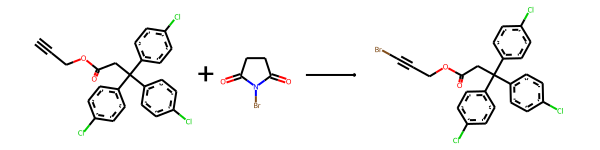

In [81]:
balance_analogue(analoguerxns3.iloc[20],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl.CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl.CC(CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl>>C[C@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](O)CCO[Si](C)(C)C(C)(C)C.C[C@@H](CCO[Si](C)(C)C(C)(C)C)OC(=O)CCl',useSmiles=True)
balance_analogue(analoguerxns3.iloc[100],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('C#CCOC(=O)CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1.O=C1CCC(=O)N1Br>>O=C(CC(c1ccc(Cl)cc1)(c1ccc(Cl)cc1)c1ccc(Cl)cc1)OCC#CBr',useSmiles=True)

Help compounds did not help. Extra reactant atoms


('c1ccc2[nH]ccc2c1>>Clc1c[nH]c2ccccc12',
 'c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',
 'Imbalanced with species: 113915',
 [107693, 113915],
 [3024],
 [],
 [],
 {107693: {'atomdict': {'C': 8, 'N': 1, 'H': 7},
   'charge': 0,
   'smiles': 'c1ccc2[nH]ccc2c1',
   'formula': 'C8H7N',
   'count': 1},
  113915: {'atomdict': {'O': 2, 'C': 4, 'N': 1, 'Cl': 1, 'H': 4},
   'charge': 0,
   'smiles': 'O=C1CCC(=O)N1Cl',
   'formula': 'C4H4ClNO2',
   'count': 1}},
 {3024: {'atomdict': {'Cl': 1, 'C': 8, 'N': 1, 'H': 6},
   'charge': 0,
   'smiles': 'Clc1c[nH]c2ccccc12',
   'formula': 'C8H6ClN',
   'count': 1}})

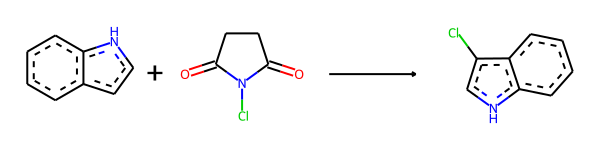

In [96]:
balance_analogue(analoguerxns3.loc[analoguerxns3.ReactionID==44420].iloc[1],basic=True,balance=True,coefflim=6,singleworkflow=True,includesolv=True,helpprod=True,helpreact=False)
rdChemReactions.ReactionFromSmarts('c1ccc2[nH]ccc2c1.O=C1CCC(=O)N1Cl>>Clc1c[nH]c2ccccc12',useSmiles=True)

First pass is balancing just the LHS of reactions (to make sure that all product atoms can be traced to reactant atoms). However, in most cases there will be a surplus of atoms on the LHS, implying there should be by-products on the RHS.

In [144]:
balrxns,analoguerxnsbal=balance_analogue_(analoguerxns3,refbalrxns=None,singleworkflow=True,reaxys_update=True,includesolv=True,
                                          helpprod=False,helpreact=False,ncpus=16)

2021-12-20 03:07:55,161	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [ ]:
import ipywidgets as widgets
def visoutput(res):
    a = widgets.IntSlider(min=0,max=len(res)-1,description='Row Number')
# b = widgets.IntSlider(description='b')
# c = widgets.IntSlider(description='c')
    def f(a):
        print(res.index[a])
        print(res.iloc[a])
        print(candirxnsbal.loc[res.index[a]])
        if res.iloc[a][1]!='Error':
            display(drawReaction(rdChemReactions.ReactionFromSmarts(res.iloc[a][0],useSmiles=True)))
            display(drawReaction(rdChemReactions.ReactionFromSmarts(res.iloc[a][1],useSmiles=True)))
            mappedrxn=maprxn([res.iloc[a][1]])
            display(drawReaction(rdChemReactions.ReactionFromSmarts(mappedrxn[0]['mapped_rxn'],useSmiles=True)))
            print(mappedrxn[0]['mapped_rxn'])
            print('Confidence Score is '+str(mappedrxn[0]['confidence']))
        
        else:
            print('Error')
            display(drawReaction(rdChemReactions.ReactionFromSmarts(res.iloc[a][0],useSmiles=True)))

        
        
    out = widgets.interactive_output(f, {'a': a})
    display(a)
    display(out)

In [ ]:
balance_analogue(analogue)

In [151]:
analoguerxnsbal.loc[analoguerxnsbal.msg.str.contains('Invalid',na=False)]

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
763,36375286,1,1,1,CC1(C)OC(=O)N(C2CC=C(c3cnc4[nH]ccc4c3)CC2)[C@H...,Error,Invalid balancing. Duplicate molecular formula...,"[24014579, 3587189]","[24014580, 24014581]",[],None,"{24014579: {'atomdict': {'C': 24, 'O': 2, 'N':...","{24014580: {'atomdict': {'C': 24, 'O': 2, 'N':..."
1372,29455111,1,1,1,Cc1cc2ccccc2[nH]1>>C[C@@H]1Cc2ccccc2N1.C[C@@H]...,Error,Invalid balancing. Duplicate molecular formula...,"[109781, 3587189]","[20360691, 6115116]",[],None,"{109781: {'atomdict': {'C': 9, 'N': 1, 'H': 9}...","{20360691: {'atomdict': {'C': 9, 'N': 1, 'H': ..."
1783,1882234,1,1,1,ClC=CC=CCl>>Cl/C=C\C(Cl)C(Cl)Cl.Cl/C=C/C(Cl)C(...,Error,Invalid balancing. Duplicate molecular formula...,"[1719703, 3902968]","[1841033, 1841034]",[],None,"{1719703: {'atomdict': {'Cl': 2, 'C': 4, 'H': ...","{1841033: {'atomdict': {'Cl': 4, 'C': 4, 'H': ..."
2014,42720569,1,1,1,C=C(C(=O)OCC)n1cnc2c(Cl)nc(F)nc21>>CCOC(=O)[C@...,Error,Invalid balancing. Duplicate molecular formula...,"[29574916, 3587189]","[29574960, 29574994]",[],None,"{29574916: {'atomdict': {'C': 10, 'O': 2, 'N':...","{29574960: {'atomdict': {'C': 10, 'O': 2, 'N':..."
4197,2645758,1,1,1,COC(=O)C1(C#N)C(=NC(C)(C)C)C(c2ccc(Cl)cc2)N1N1...,Error,"Invalid balancing. Species missing from RHS, B...","[465449, 1098229]","[118522, 4547902, 1519199]",[],None,"{465449: {'atomdict': {'C': 24, 'O': 4, 'N': 4...","{118522: {'atomdict': {'O': 2, 'C': 8, 'N': 1,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356026,9273451,3,1,1,COC(=O)C=C(NC(C)=O)c1ccc(Cl)cc1>>COC(=O)C[C@@H...,Error,Invalid balancing. Duplicate molecular formula...,"[9126692, 3587189]","[9328730, 9126691]",[],None,"{9126692: {'atomdict': {'C': 12, 'O': 3, 'N': ...","{9328730: {'atomdict': {'C': 12, 'O': 3, 'N': ..."
1356027,9273451,3,1,1,COC(=O)C=C(NC(C)=O)c1ccc(Cl)cc1>>COC(=O)C[C@@H...,Error,Invalid balancing. Duplicate molecular formula...,"[9126692, 3587189]","[9328730, 9126691]",[],None,"{9126692: {'atomdict': {'C': 12, 'O': 3, 'N': ...","{9328730: {'atomdict': {'C': 12, 'O': 3, 'N': ..."
1356760,3056725,1,1,1,CC[C@H]1COC(=O)C2=C1C[C@H]1c3[nH]c4ccccc4c3CCN...,Error,Invalid balancing. Duplicate molecular formula...,"[5302910, 3587189]","[5302912, 5302914]",[],None,"{5302910: {'atomdict': {'C': 20, 'O': 2, 'N': ...","{5302912: {'atomdict': {'C': 20, 'O': 2, 'N': ..."
1356850,39486238,1,1,1,Cc1nc2cc(Cl)c(Cl)cc2nc1-c1ccccc1>>C[C@H]1Nc2cc...,Error,Invalid balancing. Duplicate molecular formula...,"[657261, 3587189, 3587189]","[27872726, 27872727]",[],None,"{657261: {'atomdict': {'C': 15, 'N': 2, 'Cl': ...","{27872726: {'atomdict': {'C': 15, 'N': 2, 'Cl'..."


In [143]:
balrxns,analoguerxnsbal=balance_analogue_(analoguerxns3.iloc[0:100000],refbalrxns=None,singleworkflow=True,reaxys_update=True,includesolv=True,
                                          helpprod=False,helpreact=False,ncpus=16)

2021-12-20 03:06:09,825	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


In [140]:
balance_analogue(analoguerxns3.loc[224],coefflim=6,includesolv=True,helpreact=False,helpprod=False)
balance_analogue(analoguerxns3.iloc[0],coefflim=6,includesolv=True,helpreact=False,helpprod=False)
# balance_analogue(analoguerxns3.iloc[20],coefflim=1,includesolv=True,helpreact=False)

('N#CC(C#N)=CC=Cc1ccc(Cl)cc1>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N',
 'N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.CCN(CC)CC.CN(C)C=O.NO>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N',
 'Imbalanced with species: 6776315,605283,605365,3587190',
 [6776315, 6776315, 605283, 605365, 3587190],
 [6648732],
 [],
 [],
 {6776315: {'atomdict': {'N': 2, 'C': 12, 'Cl': 1, 'H': 7},
   'charge': 0,
   'smiles': 'N#CC(C#N)=CC=Cc1ccc(Cl)cc1',
   'formula': 'C12H7ClN2',
   'count': 2},
  605283: {'atomdict': {'C': 6, 'N': 1, 'H': 15},
   'charge': 0,
   'smiles': 'CCN(CC)CC',
   'formula': 'C6H15N',
   'count': 1},
  605365: {'atomdict': {'C': 3, 'N': 1, 'O': 1, 'H': 7},
   'charge': 0,
   'smiles': 'CN(C)C=O',
   'formula': 'C3H7NO',
   'count': 1},
  3587190: {'atomdict': {'N': 1, 'O': 1, 'H': 3},
   'charge': 0,
   'smiles': 'NO',
   'formula': 'H3NO',
   'count': 1}},
 {6648732: {'atomdict': {'N': 3, 'C': 12, 'Cl': 1, 'H': 8},
   'charge': 0,
   'smiles': 'N#Cc1ccc(-c2ccc(Cl)cc2)nc1N',
   'formula': 'C12H8ClN3',
 

('O=C(Cl)c1cccs1.Nc1ccc(Cl)cc1>>O=C(Nc1ccc(Cl)cc1)c1cccs1',
 'O=C(Cl)c1cccs1.Nc1ccc(Cl)cc1>>O=C(Nc1ccc(Cl)cc1)c1cccs1',
 'Imbalanced',
 [110145, 471359],
 [162172],
 [],
 [],
 {110145: {'atomdict': {'O': 1, 'C': 5, 'Cl': 1, 'S': 1, 'H': 3},
   'charge': 0,
   'smiles': 'O=C(Cl)c1cccs1',
   'formula': 'C5H3ClOS',
   'count': 1},
  471359: {'atomdict': {'N': 1, 'C': 6, 'Cl': 1, 'H': 6},
   'charge': 0,
   'smiles': 'Nc1ccc(Cl)cc1',
   'formula': 'C6H6ClN',
   'count': 1}},
 {162172: {'atomdict': {'O': 1, 'C': 11, 'N': 1, 'Cl': 1, 'S': 1, 'H': 8},
   'charge': 0,
   'smiles': 'O=C(Nc1ccc(Cl)cc1)c1cccs1',
   'formula': 'C11H8ClNOS',
   'count': 1}})

array(['Balanced with help product(s): HCl',
       'Imbalanced with species: 2694054',
       'Imbalanced with species: 3311977',
       'Imbalanced with species: 1733365',
       'Balanced with species: 3587191 with help product(s): H2O',
       'Imbalanced', 'Balanced with help product(s): H2',
       'Balanced with help product(s): H2O',
       'Balanced with species: 3587189',
       'Imbalanced with species: 4243185,1708400,3587329,969212',
       'Imbalanced with species: 4243185,3587329',
       'Imbalanced with species: 1098214',
       'Imbalanced with species: 4783054,4783054',
       'Imbalanced with species: 3592982',
       'Imbalanced with species: 5896444', 'Already balanced',
       'Balanced with help product(s): HI',
       'Imbalanced with species: 2151660,8127944,1098214',
       'Imbalanced with species: 2580622,1718733,11343078,102391',
       'Balanced with species: 7439719,1209246,3587191 with help product(s): CH4',
       'Imbalanced with species: 11342939',
 

,ReactionID,NumRefs,NumSteps,NumStages,rxnsmiles0,balrxnsmiles,msg,LHS,RHS,hcrct,hcprod,LHSdata,RHSdata
224,34671415,1,1,1,N#CC(C#N)=CC=Cc1ccc(Cl)cc1>>N#Cc1ccc(-c2ccc(Cl...,N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc...,"Balanced with species: 6776315,605283,605365,3...","[6776315, 6776315, 6776315, 6776315, 605283, 6...","[6648732, 6648732, 6648732, 6648732]",[],[23],"{6776315: {'atomdict': {'N': 2, 'C': 12, 'Cl':...","{6648732: {'atomdict': {'N': 3, 'C': 12, 'Cl':..."


'N#CC(C#N)=CC=Cc1ccc(Cl)cc1>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N'

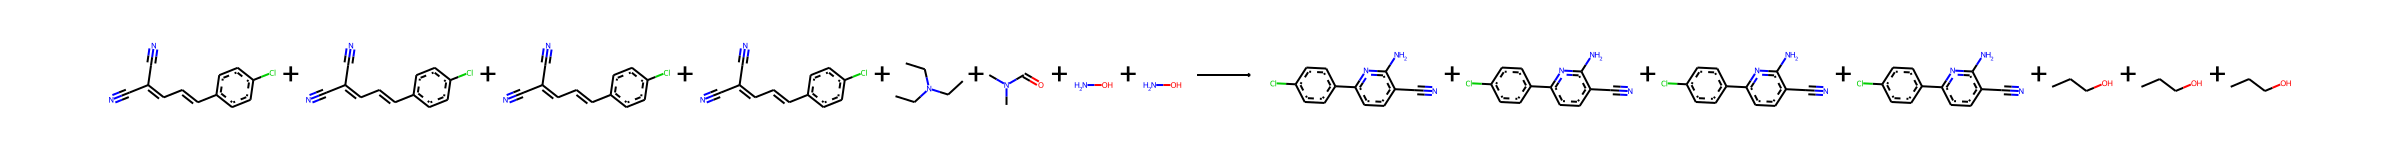

In [121]:
analoguerxnsbal.msg.unique()
demosmiles=analoguerxnsbal.loc[analoguerxnsbal.msg=='Balanced with species: 6776315,605283,605365,3587190 with help product(s): C3H8O'].iloc[0].balrxnsmiles
analoguerxnsbal.loc[analoguerxnsbal.msg=='Balanced with species: 6776315,605283,605365,3587190 with help product(s): C3H8O']
analoguerxnsbal.loc[analoguerxnsbal.msg=='Balanced with species: 6776315,605283,605365,3587190 with help product(s): C3H8O'].iloc[0].rxnsmiles0
rdChemReactions.ReactionFromSmarts(demosmiles,useSmiles=True)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


[{'mapped_rxn': 'CCN(CC)CC.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.O[NH2:14].[N:1]#[C:2][C:3](=[CH:4][CH:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]1)[C:15]#[N:16]>>[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6](-[c:7]2[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]2)[n:14][c:15]1[NH2:16]',
  'confidence': 0.3053072816106079}]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


[{'mapped_rxn': 'CCN(CC)CC.CN(C)C=O.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.O[NH2:14].[N:1]#[C:2][C:3](=[CH:4][CH:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]1)[C:15]#[N:16]>>[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6](-[c:7]2[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]2)[n:14][c:15]1[NH2:16]',
  'confidence': 0.21538310948592618}]

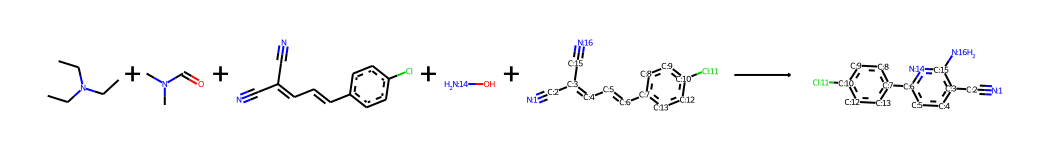

In [128]:
maprxn(['N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.CCN(CC)CC.NO>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N'])
maprxn(['N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.CCN(CC)CC.CN(C)C=O.NO>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N'])
rdChemReactions.ReactionFromSmarts('CCN(CC)CC.CN(C)C=O.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.O[NH2:14].[N:1]#[C:2][C:3](=[CH:4][CH:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]1)[C:15]#[N:16]>>[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6](-[c:7]2[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]2)[n:14][c:15]1[NH2:16]',useSmiles=True)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


[{'mapped_rxn': '[CH3:1][CH2:2][N:42]([CH2:7][CH3:6])[CH2:11][CH3:10].[CH:3](=[O:4])[N:26]([CH3:5])[CH3:9].[N:13]#[C:14][C:15](=[CH:16][CH:17]=[CH:18][c:19]1[cH:20][cH:21][c:22]([Cl:23])[cH:24][cH:25]1)[C:27]#[N:28].[N:29]#[C:30][C:31](=[CH:32][CH:33]=[CH:34][c:35]1[cH:36][cH:37][c:38]([Cl:39])[cH:40][cH:41]1)[C:43]#[N:44].[N:45]#[C:46][C:47](=[CH:48][CH:49]=[CH:50][c:51]1[cH:52][cH:53][c:54]([Cl:55])[cH:56][cH:57]1)[C:59]#[N:60].[N:61]#[C:62][C:63](=[CH:64][CH:65]=[CH:66][c:67]1[cH:68][cH:69][c:70]([Cl:71])[cH:72][cH:73]1)[C:75]#[N:76].[OH:12][NH2:58].[OH:8][NH2:74]>>[CH3:1][CH2:2][CH2:3][OH:4].[CH3:5][CH2:6][CH2:7][OH:8].[CH3:9][CH2:10][CH2:11][OH:12].[N:13]#[C:14][c:15]1[cH:16][cH:17][c:18](-[c:19]2[cH:20][cH:21][c:22]([Cl:23])[cH:24][cH:25]2)[n:26][c:27]1[NH2:28].[N:29]#[C:30][c:31]1[cH:32][cH:33][c:34](-[c:35]2[cH:36][cH:37][c:38]([Cl:39])[cH:40][cH:41]2)[n:42][c:43]1[NH2:44].[N:45]#[C:46][c:47]1[cH:48][cH:49][c:50](-[c:51]2[cH:52][cH:53][c:54]([Cl:55])[cH:56][cH:57]2)[n:58][c:59]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
Keyword arguments {'return_special_tokens_masks': True} not recognized.


[{'mapped_rxn': '[N:1]#[C:2][C:3](=[CH:4][CH:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]1)[C:15]#[N:14]>>[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6](-[c:7]2[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]2)[n:14][c:15]1[NH2:16]',
  'confidence': 0.8917719325900024}]

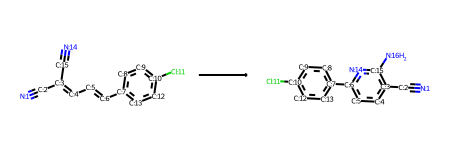

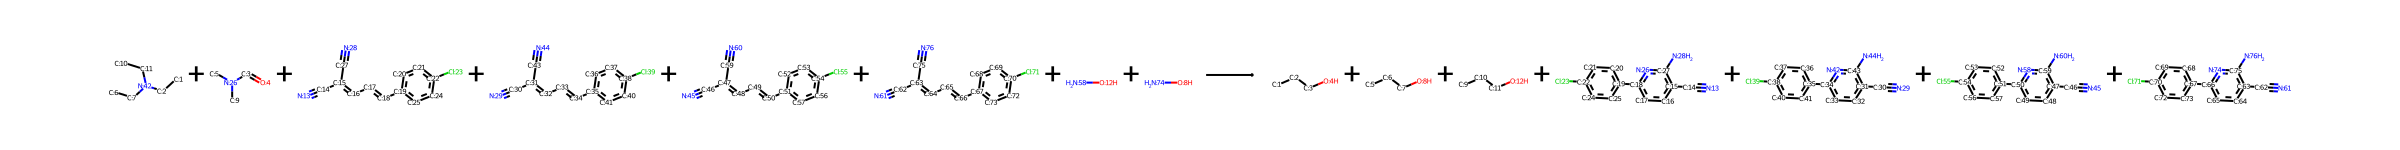

In [120]:
maprxn(['N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.N#CC(C#N)=CC=Cc1ccc(Cl)cc1.CCN(CC)CC.CN(C)C=O.NO.NO>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N.N#Cc1ccc(-c2ccc(Cl)cc2)nc1N.N#Cc1ccc(-c2ccc(Cl)cc2)nc1N.N#Cc1ccc(-c2ccc(Cl)cc2)nc1N.CCCO.CCCO.CCCO'])
maprxn(['N#CC(C#N)=CC=Cc1ccc(Cl)cc1>>N#Cc1ccc(-c2ccc(Cl)cc2)nc1N'])
rdChemReactions.ReactionFromSmarts('[N:1]#[C:2][C:3](=[CH:4][CH:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]1)[C:15]#[N:14]>>[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6](-[c:7]2[cH:8][cH:9][c:10]([Cl:11])[cH:12][cH:13]2)[n:14][c:15]1[NH2:16]',useSmiles=True)
rdChemReactions.ReactionFromSmarts('[CH3:1][CH2:2][N:42]([CH2:7][CH3:6])[CH2:11][CH3:10].[CH:3](=[O:4])[N:26]([CH3:5])[CH3:9].[N:13]#[C:14][C:15](=[CH:16][CH:17]=[CH:18][c:19]1[cH:20][cH:21][c:22]([Cl:23])[cH:24][cH:25]1)[C:27]#[N:28].[N:29]#[C:30][C:31](=[CH:32][CH:33]=[CH:34][c:35]1[cH:36][cH:37][c:38]([Cl:39])[cH:40][cH:41]1)[C:43]#[N:44].[N:45]#[C:46][C:47](=[CH:48][CH:49]=[CH:50][c:51]1[cH:52][cH:53][c:54]([Cl:55])[cH:56][cH:57]1)[C:59]#[N:60].[N:61]#[C:62][C:63](=[CH:64][CH:65]=[CH:66][c:67]1[cH:68][cH:69][c:70]([Cl:71])[cH:72][cH:73]1)[C:75]#[N:76].[OH:12][NH2:58].[OH:8][NH2:74]>>[CH3:1][CH2:2][CH2:3][OH:4].[CH3:5][CH2:6][CH2:7][OH:8].[CH3:9][CH2:10][CH2:11][OH:12].[N:13]#[C:14][c:15]1[cH:16][cH:17][c:18](-[c:19]2[cH:20][cH:21][c:22]([Cl:23])[cH:24][cH:25]2)[n:26][c:27]1[NH2:28].[N:29]#[C:30][c:31]1[cH:32][cH:33][c:34](-[c:35]2[cH:36][cH:37][c:38]([Cl:39])[cH:40][cH:41]2)[n:42][c:43]1[NH2:44].[N:45]#[C:46][c:47]1[cH:48][cH:49][c:50](-[c:51]2[cH:52][cH:53][c:54]([Cl:55])[cH:56][cH:57]2)[n:58][c:59]1[NH2:60].[N:61]#[C:62][c:63]1[cH:64][cH:65][c:66](-[c:67]2[cH:68][cH:69][c:70]([Cl:71])[cH:72][cH:73]2)[n:74][c:75]1[NH2:76]',useSmiles=True)